In [4]:
import numpy as np
import random
import itertools as it
import os, subprocess
import sys
import time
import pickle

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mycolorpy import colorlist as mcp

import proplot as pplt

from UQpy.distributions import Normal, Uniform, JointIndependent

import scipy
from scipy.integrate import odeint
import scipy.special

import SALib
from SALib.sample import saltelli

# sys.path.append('../GDMaps_PCE/')
from GDMaps_PCE.DimensionReduction import Grassmann
from GDMaps_PCE.DimensionReduction import DiffusionMaps
from GDMaps_PCE.GDMaps_PCE_GSA_wLAR import *

# Plotting parameters
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["legend.fontsize"] = 12.5
mpl.rcParams["font.size"] = 13.5
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.2
mpl.rcParams["axes.axisbelow"] = True
mpl.rcParams["figure.figsize"] = (6, 4)
mpl.rcParams["mathtext.fontset"] = "stix" # "cm"
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 15

USE_TEX = False

if USE_TEX:
    plt.rc("text", usetex=True)
    plt.rc("text.latex", preamble=r"""
     \usepackage{times}
     \usepackage{mathptmx}""")
else:
    plt.rc("text", usetex=False)
    
plt.rc("font", family="serif")

mpl.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


ImportError: cannot import name 'Kriging' from 'UQpy.surrogates' (C:\Users\arend\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\UQpy\surrogates\__init__.py)

In [8]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.6.3


: 

In [2]:
if not os.path.exists('plots/main_text'):
    os.makedirs('plots/main_text')
    
if not os.path.exists('plots/appendix'):
    os.makedirs('plots/appendix')
    
if not os.path.exists('data/data_DeepABM/GSA_results/GDMaps'):
    os.makedirs('data/data_DeepABM/GSA_results/GDMaps')
    
if not os.path.exists('data/data_DeepABM/GSA_results/PCE_GSA'):
    os.makedirs('data/data_DeepABM/GSA_results/PCE_GSA')

In [3]:
samples       = np.asarray(range(1024*7))
response_vars = ['SUSCEPTIBLE', 'HOSPITALIZED', 'DEATH', 'RECOVERED', 'ACTIVE']

num_steps     = 180
num_runs      = 20
num_responses = len(response_vars)
num_samples   = len(samples)


In [4]:
with open('data/data_DeepABM/results_all_array.pickle', 'rb') as f:
    results_all = pickle.load(f)

In [5]:
print(results_all.shape)

(20, 7168, 5, 180)


In [6]:
# input pararameters
problem = {
  'num_vars': 5, 
  'names': ['R', 
            'SFSusceptibility_Scalar', 
            'SFInfector_Scalar', 
            'B_n_Scalar',
            'lam_gamma_Scalar'],
  'bounds': [[1.9, 6.5], 
             [0.5, 1.5],
             [0.5, 1.5], 
             [0.7, 1.3],
             [0.7, 1.3]]
}

param_names_short = {'R': r'$R$',
            'SFSusceptibility_Scalar': r'$S_F$', 
            'SFInfector_Scalar': r'$A_F$',
            'B_n_Scalar': r'$B_F$',
            'lam_gamma_Scalar': r'$\Gamma_F$', 
}

In [7]:
n_distinct_samples = 2048 #1024

param_vals = saltelli.sample(problem, n_distinct_samples, calc_second_order=False)
saltelli_2048 = np.loadtxt('data/data_DeepABM/saltellisample_2048')

print(np.array_equal(param_vals, param_vals))


True


In [8]:
# Probability distributions of input parameters
# corresponding to the bounds 
print(f'Problem bounds: {problem["bounds"]}')

pdf1 = Uniform(loc=1.9, scale=4.6)  
pdf2 = Uniform(loc=0.5, scale=1.0)  
pdf3 = Uniform(loc=0.5, scale=1.0)
pdf4 = Uniform(loc=0.7, scale=0.6)
pdf5 = Uniform(loc=0.7, scale=0.6)

margs = [pdf1, pdf2, pdf3, pdf4, pdf5]
joint = JointIndependent(marginals=margs)

Problem bounds: [[1.9, 6.5], [0.5, 1.5], [0.5, 1.5], [0.7, 1.3], [0.7, 1.3]]


# Five response variables

In [9]:
# Flatten results

results_flat_run_all = np.zeros((num_runs, num_samples, num_responses*num_steps))

for run in range(num_runs):
    results_flat = np.zeros((num_samples, num_responses*num_steps))
    for sample_idx, sample in enumerate(samples):
        results_flat[sample_idx, :] = results_all[run][sample_idx].ravel()
    results_flat_run_all[run] = results_flat 
    

In [10]:
n2 = results_flat_run_all[0].shape[1]

In [11]:
# Input used in running DeepABM: 1024*7

saltelli_1024 = saltelli_2048[:num_samples]


# Ranks

In [34]:
# Ranks to plot as histogram
ranks = []

for i in range(num_runs):
    data_all = results_flat_run_all[i].reshape(-1, 
                               int(np.sqrt(n2)), 
                               int(np.sqrt(n2)))
    
    ranks += [np.linalg.matrix_rank(data_all[i]) for i \
         in range(len(data_all))]

unique, counts = np.unique(ranks, return_counts=True)
print(f'Ranks: \n {np.asarray((unique, counts)).T}')


Ranks: 
 [[    2  2430]
 [    3 14544]
 [    4  3128]
 [    5  3795]
 [    6  1797]
 [    7  1654]
 [    8   804]
 [    9   668]
 [   10   711]
 [   11  1016]
 [   12  1833]
 [   13  8385]
 [   14  6718]
 [   15  7422]
 [   16  7324]
 [   17  9361]
 [   18  7000]
 [   19  6952]
 [   20  6442]
 [   21  7333]
 [   22  9554]
 [   23 14995]
 [   24 12148]
 [   25  7346]]


# GDMaps: parsim and non-parsim

In [12]:
# List of Grassmannian dimensions p (top unique values from ranks)
p_array = [3, 13, 17, 22, 23, 24]


In [39]:
reshaped_res = results_flat_run_all.reshape(20, 7168, 
                                            int(np.sqrt(n2)), 
                                            int(np.sqrt(n2)))

In [40]:
# parsim

# change 10_runs to 20_runs

for p in p_array:
    print(f'p={p}')

    if not os.path.exists(f'data/data_DeepABM/GSA_results/GDMaps/DeepABM_parsim_20_runs_p_{p}.npz'):
        result = run_GDMaps(p=p, data=reshaped_res, num_runs=20)

        np.savez(f'data/data_DeepABM/GSA_results/GDMaps//DeepABM_parsim_20_runs_p_{p}.npz', 
                 x1 = result[0],  # evals_diff_runs
                 x2 = result[1],  # evecs_diff_runs
                 x3 = result[2],  # coord_diff_runs
                 x4 = result[3],  # g_diff_runs
                 x5 = result[4],  # residuals_diff_runs
                 x6 = result[5],  # index_diff_runs
                )

p=3
Run:  0
Running with parsimonious representation
--- GDMaps - 1725.1077392101288 seconds ---
Run:  1
Running with parsimonious representation
--- GDMaps - 1418.8253672122955 seconds ---
Run:  2
Running with parsimonious representation
--- GDMaps - 1550.1717109680176 seconds ---
Run:  3
Running with parsimonious representation
--- GDMaps - 1515.5948112010956 seconds ---
Run:  4
Running with parsimonious representation
--- GDMaps - 1477.747044801712 seconds ---
Run:  5
Running with parsimonious representation
--- GDMaps - 1570.2293870449066 seconds ---
Run:  6
Running with parsimonious representation
--- GDMaps - 1576.6343619823456 seconds ---
Run:  7
Running with parsimonious representation
--- GDMaps - 1412.3312168121338 seconds ---
Run:  8
Running with parsimonious representation
--- GDMaps - 1375.9684090614319 seconds ---
Run:  9
Running with parsimonious representation
--- GDMaps - 1342.6586430072784 seconds ---
Run:  10
Running with parsimonious representation
--- GDMaps - 1361

Running with parsimonious representation
--- GDMaps - 1387.1806991100311 seconds ---
Run:  9
Running with parsimonious representation
--- GDMaps - 1385.8889050483704 seconds ---
Run:  10
Running with parsimonious representation
--- GDMaps - 1392.706020116806 seconds ---
Run:  11
Running with parsimonious representation
--- GDMaps - 1394.0808098316193 seconds ---
Run:  12
Running with parsimonious representation
--- GDMaps - 1395.4622757434845 seconds ---
Run:  13
Running with parsimonious representation
--- GDMaps - 1389.521322965622 seconds ---
Run:  14
Running with parsimonious representation
--- GDMaps - 1394.8750121593475 seconds ---
Run:  15
Running with parsimonious representation
--- GDMaps - 1393.5075800418854 seconds ---
Run:  16
Running with parsimonious representation
--- GDMaps - 1393.3513300418854 seconds ---
Run:  17
Running with parsimonious representation
--- GDMaps - 1392.3605110645294 seconds ---
Run:  18
Running with parsimonious representation
--- GDMaps - 1384.4980

In [42]:
# nonparsim

for p in p_array:
    print(f'p={p}')
    
    if not os.path.exists(f'data/data_DeepABM/GSA_results/GDMaps/DeepABM_nonparsim_20_runs_p_{p}.npz'):
    
        result_parsim = np.load(f'data/data_DeepABM/GSA_results/GDMaps/DeepABM_parsim_20_runs_p_{p}.npz', 
                                allow_pickle=True)

        evals = result_parsim['x1']
        evecs = result_parsim['x2']
        coord = result_parsim['x3']
        d_coords_parsim = result_parsim['x4']   
        residuals = result_parsim['x5']   
        index = result_parsim['x6']   
    
        d_coords_nonparsim = []
        for run in range(num_runs):
            d_coords_nonparsim.append(nonparsim_dcoord(num_samples, 3, evecs[run], evals[run]))
    
        np.savez(f'data/data_DeepABM/GSA_results/GDMaps/DeepABM_nonparsim_20_runs_p_{p}.npz', 
                 x1 = evals,  # evals
                 x2 = evecs,  # evecs
                 x3 = np.array([1,2,3]),  # coord
                 x4 = d_coords_nonparsim,  # g
                )
        

p=3
p=13
p=17
p=22
p=23
p=24


# GSA results using LAR

In [ ]:
p_s = [3, 13, 23]

s_max = np.linspace(3, 15, 5, dtype='int') # change

x = saltelli_1024

for p in p_s:
    print(f'p={p}')

    if not os.path.exists(f'data/data_DeepABM/GSA_results/PCE_GSA/DeepABM_smax_3_24_parsim_p_{p}.npz'):
        
        result_parsim = np.load(f'data/data_DeepABM/GSA_results/GDMaps/DeepABM_parsim_20_runs_p_{p}.npz', 
                                allow_pickle=True)
        
        d_coords_parsim = result_parsim['x4']
        
        PCE_results = two_regressions_PCE(x=x, 
                                          dist_obj=joint,
                                          s_max=s_max,
                                          d_coords=d_coords_parsim,
                                          n_runs=20, 
                                          n_dcoords=3)

        np.savez(f'data/data_DeepABM/GSA_results/PCE_GSA/DeepABM_smax_3_24_parsim_p_{p}.npz', 
                 x1 = PCE_results[0], # ols_fo_si 
                 x2 = PCE_results[1], # ols_to_si
                 x3 = PCE_results[2], # ols_error
                 x4 = PCE_results[3], # ols_LOO
                 x5 = PCE_results[4], # LAR_fo_si
                 x6 = PCE_results[5], # LAR_to_si
                 x7 = PCE_results[6],# LAR_error
                 x8 = PCE_results[7],# LAR_LOO
                 x9 = PCE_results[8] # LAR_MAE
                )

p=3
Run: 0
Max polynomial degree: 3
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 47
Mean absolute error: 0.0015326336094696519
Leave-one-out cross validation on ED: 0.1622376
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 33
Mean absolute error: 0.0004206674212745821
Leave-one-out cross validation on ED: 0.7440828
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 47
Mean absolute error: 0.001948665816597964
Leave-one-out cross validation on ED: 0.4355549
--- PCE-OLD and PCE-LAR - 7.868106126785278 seconds ---
Max polynomial degree: 6
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 143
Mean absolute error: 0.0013852088176043353
Leave-one-out cross validation on ED: 0.1391574
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 158
Mean absolute error: 0.00040745330118737046
Leave-one-out cross validation on ED: 0.6453041
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 158
Mean absolute 

Mean absolute error: 0.0013330638490972177
Leave-one-out cross validation on ED: 0.2655888
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 889
Mean absolute error: 0.00016769635714107252
Leave-one-out cross validation on ED: 0.6560564
--- PCE-OLD and PCE-LAR - 5547.57630610466 seconds ---
Run: 3
Max polynomial degree: 3
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 49
Mean absolute error: 0.0017601669942014808
Leave-one-out cross validation on ED: 0.2038407
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 47
Mean absolute error: 0.0020142290372750253
Leave-one-out cross validation on ED: 0.4821523
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 33
Mean absolute error: 0.00022647610238066656
Leave-one-out cross validation on ED: 0.9124774
--- PCE-OLD and PCE-LAR - 8.150392055511475 seconds ---
Max polynomial degree: 6
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 105
Mean absolute error: 0.001655

Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 125
Mean absolute error: 0.0017243060075745882
Leave-one-out cross validation on ED: 0.1908867
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 173
Mean absolute error: 0.0013044673792320211
Leave-one-out cross validation on ED: 0.2504418
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 945
Mean absolute error: 0.00031072996243847135
Leave-one-out cross validation on ED: 0.6683494
--- PCE-OLD and PCE-LAR - 5538.453491926193 seconds ---
Run: 6
Max polynomial degree: 3
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 43
Mean absolute error: 0.001733192489112107
Leave-one-out cross validation on ED: 0.1969814
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 51
Mean absolute error: 0.0019918264211600334
Leave-one-out cross validation on ED: 0.4745698
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 21
Mean absolute error: 0.00026893124032

Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 816
Mean absolute error: 0.00031183450846859046
Leave-one-out cross validation on ED: 0.7584106
--- PCE-OLD and PCE-LAR - 1631.057775735855 seconds ---
Max polynomial degree: 15
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 131
Mean absolute error: 0.0017650343672448636
Leave-one-out cross validation on ED: 0.1735527
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 195
Mean absolute error: 0.0014013799225541408
Leave-one-out cross validation on ED: 0.2502199
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 916
Mean absolute error: 0.00032184617545189334
Leave-one-out cross validation on ED: 0.698814
--- PCE-OLD and PCE-LAR - 5571.427677869797 seconds ---
Run: 9
Max polynomial degree: 3
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 48
Mean absolute error: 0.0016924801548959564
Leave-one-out cross validation on ED: 0.2037462
Size of the full se

Size of the LAR PCE basis: 104
Mean absolute error: 0.0017259142905652746
Leave-one-out cross validation on ED: 0.1865652
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 893
Mean absolute error: 0.00030986871129613975
Leave-one-out cross validation on ED: 0.4705558
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 186
Mean absolute error: 0.0013229426037506978
Leave-one-out cross validation on ED: 0.2518719
--- PCE-OLD and PCE-LAR - 1657.516803741455 seconds ---
Max polynomial degree: 15
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 94
Mean absolute error: 0.0017218422989916946
Leave-one-out cross validation on ED: 0.1881049
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 967
Mean absolute error: 0.00033413797739917394
Leave-one-out cross validation on ED: 0.4745873
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 193
Mean absolute error: 0.0013319556263263039
Leave-one-out cross validation

Size of the full set of PCE basis: 2002
Size of the LAR PCE basis: 410
Mean absolute error: 0.0002772899538911202
Leave-one-out cross validation on ED: 0.8425597
--- PCE-OLD and PCE-LAR - 1186.6929609775543 seconds ---
Max polynomial degree: 12
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 132
Mean absolute error: 0.0017063418480497798
Leave-one-out cross validation on ED: 0.1827887
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 253
Mean absolute error: 0.001343721778201749
Leave-one-out cross validation on ED: 0.2438719
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 952
Mean absolute error: 0.0003101521659844505
Leave-one-out cross validation on ED: 0.7403472
--- PCE-OLD and PCE-LAR - 1644.5155918598175 seconds ---
Max polynomial degree: 15
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 100
Mean absolute error: 0.0017393686698529759
Leave-one-out cross validation on ED: 0.1857671
Size of the full set of 

Size of the LAR PCE basis: 100
Mean absolute error: 0.0016469432771067988
Leave-one-out cross validation on ED: 0.1980029
Size of the full set of PCE basis: 2002
Size of the LAR PCE basis: 141
Mean absolute error: 0.001312295740811755
Leave-one-out cross validation on ED: 0.2648072
Size of the full set of PCE basis: 2002
Size of the LAR PCE basis: 455
Mean absolute error: 0.00024967374776174034
Leave-one-out cross validation on ED: 0.8092245
--- PCE-OLD and PCE-LAR - 1120.1203062534332 seconds ---
Max polynomial degree: 12
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 141
Mean absolute error: 0.0017844101905874906
Leave-one-out cross validation on ED: 0.1887088
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 176
Mean absolute error: 0.0013160190861203716
Leave-one-out cross validation on ED: 0.2548162
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 939
Mean absolute error: 0.0002816113947173679
Leave-one-out cross validation on

Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 205
Mean absolute error: 0.0001731585389897906
Leave-one-out cross validation on ED: 0.6874371
--- PCE-OLD and PCE-LAR - 231.8349642753601 seconds ---
Max polynomial degree: 9
Size of the full set of PCE basis: 2002
Size of the LAR PCE basis: 132
Mean absolute error: 0.0008101897304913936
Leave-one-out cross validation on ED: 0.2117619
Size of the full set of PCE basis: 2002
Size of the LAR PCE basis: 249
Mean absolute error: 0.0009055270101070103
Leave-one-out cross validation on ED: 0.2246949
Size of the full set of PCE basis: 2002
Size of the LAR PCE basis: 676
Mean absolute error: 0.00016313370391493427
Leave-one-out cross validation on ED: 0.5437794
--- PCE-OLD and PCE-LAR - 1194.264243364334 seconds ---
Max polynomial degree: 12
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 128
Mean absolute error: 0.000814922854383498
Leave-one-out cross validation on ED: 0.2064951
Size of the full set of PCE 

Size of the LAR PCE basis: 120
Mean absolute error: 0.0009247703211166032
Leave-one-out cross validation on ED: 0.3431801
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 191
Mean absolute error: 0.0009825351954554425
Leave-one-out cross validation on ED: 0.2864618
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 103
Mean absolute error: 4.572848768603844e-05
Leave-one-out cross validation on ED: 0.9554551
--- PCE-OLD and PCE-LAR - 187.87083864212036 seconds ---
Max polynomial degree: 9
Size of the full set of PCE basis: 2002
Size of the LAR PCE basis: 169
Mean absolute error: 0.000989563973525534
Leave-one-out cross validation on ED: 0.3279361
Size of the full set of PCE basis: 2002
Size of the LAR PCE basis: 135
Mean absolute error: 0.0008963214351912779
Leave-one-out cross validation on ED: 0.2702258
Size of the full set of PCE basis: 2002
Size of the LAR PCE basis: 398
Mean absolute error: 4.918159820195497e-05
Leave-one-out cross validation on ED:

Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 15
Mean absolute error: 6.936229999209725e-05
Leave-one-out cross validation on ED: 0.9907052
--- PCE-OLD and PCE-LAR - 6.491569995880127 seconds ---
Max polynomial degree: 6
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 103
Mean absolute error: 0.0009187110353966345
Leave-one-out cross validation on ED: 0.3155326
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 181
Mean absolute error: 0.000965425527674241
Leave-one-out cross validation on ED: 0.2895346
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 140
Mean absolute error: 6.973445407648956e-05
Leave-one-out cross validation on ED: 0.9429008
--- PCE-OLD and PCE-LAR - 204.84650373458862 seconds ---
Max polynomial degree: 9
Size of the full set of PCE basis: 2002
Size of the LAR PCE basis: 121
Mean absolute error: 0.0009716836638733889
Leave-one-out cross validation on ED: 0.305335
Size of the full set of PCE basis: 

Size of the LAR PCE basis: 38
Mean absolute error: 0.0010042307083288045
Leave-one-out cross validation on ED: 0.3428552
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 47
Mean absolute error: 0.001196070693968494
Leave-one-out cross validation on ED: 0.4386156
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 12
Mean absolute error: 4.647125168116874e-05
Leave-one-out cross validation on ED: 0.9954544
--- PCE-OLD and PCE-LAR - 6.729594945907593 seconds ---
Max polynomial degree: 6
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 110
Mean absolute error: 0.0008977888392721257
Leave-one-out cross validation on ED: 0.3102505
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 160
Mean absolute error: 0.000972471378697192
Leave-one-out cross validation on ED: 0.2961161
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 62
Mean absolute error: 4.7163203615289365e-05
Leave-one-out cross validation on ED: 0.9709665

Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 192
Mean absolute error: 0.0009179017018695972
Leave-one-out cross validation on ED: 0.2564003
--- PCE-OLD and PCE-LAR - 5500.07239317894 seconds ---
Run: 12
Max polynomial degree: 3
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 38
Mean absolute error: 0.0010308762676871145
Leave-one-out cross validation on ED: 0.3432781
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 48
Mean absolute error: 0.0011677448068210684
Leave-one-out cross validation on ED: 0.412934
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 12
Mean absolute error: 4.2139603295249685e-05
Leave-one-out cross validation on ED: 0.9954798
--- PCE-OLD and PCE-LAR - 6.4546589851379395 seconds ---
Max polynomial degree: 6
Size of the full set of PCE basis: 462
Size of the LAR PCE basis: 112
Mean absolute error: 0.0009226569153976855
Leave-one-out cross validation on ED: 0.3108732
Size of the full set of PCE b

Size of the LAR PCE basis: 120
Mean absolute error: 0.0010122016294036975
Leave-one-out cross validation on ED: 0.3006595
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 96
Mean absolute error: 0.0009385811921446102
Leave-one-out cross validation on ED: 0.2905147
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 807
Mean absolute error: 4.932841248804601e-05
Leave-one-out cross validation on ED: 0.7469139
--- PCE-OLD and PCE-LAR - 5439.851724147797 seconds ---
Run: 15
Max polynomial degree: 3
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 38
Mean absolute error: 0.001009793201243359
Leave-one-out cross validation on ED: 0.3445714
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 49
Mean absolute error: 0.0011978447064313349
Leave-one-out cross validation on ED: 0.4209321
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 9
Mean absolute error: 4.227017904061295e-05
Leave-one-out cross validation on ED:

Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 886
Mean absolute error: 5.257382001630955e-05
Leave-one-out cross validation on ED: 0.7616556
--- PCE-OLD and PCE-LAR - 1580.9333808422089 seconds ---
Max polynomial degree: 15
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 76
Mean absolute error: 0.000956385050123993
Leave-one-out cross validation on ED: 0.3207295
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 131
Mean absolute error: 0.00088379303878358
Leave-one-out cross validation on ED: 0.2661931
Size of the full set of PCE basis: 15504
Size of the LAR PCE basis: 809
Mean absolute error: 5.098686729832465e-05
Leave-one-out cross validation on ED: 0.7230107
--- PCE-OLD and PCE-LAR - 5442.38454914093 seconds ---
Run: 18
Max polynomial degree: 3
Size of the full set of PCE basis: 56
Size of the LAR PCE basis: 38
Mean absolute error: 0.0010611025681792846
Leave-one-out cross validation on ED: 0.3742452
Size of the full set of

Size of the LAR PCE basis: 117
Mean absolute error: 0.00036268747223888454
Leave-one-out cross validation on ED: 0.3459523
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 986
Mean absolute error: 8.41183185054458e-05
Leave-one-out cross validation on ED: 0.5503305
Size of the full set of PCE basis: 6188
Size of the LAR PCE basis: 880
Mean absolute error: 2.61492399127365e-05
Leave-one-out cross validation on ED: 0.8000824
--- PCE-OLD and PCE-LAR - 2593.4569540023804 seconds ---
Max polynomial degree: 15


# PLOTS

In [9]:
PATH = "data/data_DeepABM/GSA_results/"

In [13]:
def plot_GSA_diff_smax(SIs, suptitle, figsize, legend_n_cols,toplabels, title, top=True):
    
    n_res = len(SIs)
    
    n_d_coord = 3
    
    s_max = np.linspace(3, 15, 5, dtype='int')
    
    param_names = param_names_short.values()
    colors = mcp.gen_color(cmap="Dark2",n=9)
    marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
    
    fig, axs = pplt.subplots(ncols=n_res, nrows=3, figsize=figsize, sharex=True, sharey=True)
    
    for d in range(n_d_coord):
        for i, param in enumerate(param_names):
            for j, si in enumerate(SIs):

                axs[d,j].scatter(s_max, si.mean(axis=0)[:, i, d], label=param,
                                 color=colors[i], edgecolor="k", marker=marker_styles[i], 
                                 markersize=80, linewidth=0.4, zorder=3)
                axs[d,j].errorbar(s_max, si.mean(axis=0)[:, i, d],
                                  si.var(axis=0, ddof=1)[:, i, d],
                                  markeredgewidth=1.4, color=colors[i],
                                  linestyle='--', capsize=7, alpha=1, elinewidth=1) 
     
   
    axs.format(toplabels=toplabels,
              suptitle=suptitle,
              leftlabels=[r"$\mathbf{\theta}_1$", 
                          r"$\mathbf{\theta}_2$",
                          r"$\mathbf{\theta}_3$"],)

    for i, ax in enumerate(axs):
        ax.format(abc='(a)')
        ax.set(ylim=(-0.06, 1.02))
        ax.format(rc_kw={'suptitle.size': 22,
                         'suptitle.pad': 5.0,
                         'suptitle.color': "k",
                         'title.size': 22,
                         'abc.size': 20,
                         'title.pad': 3.0,
                         'label.size': 22,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 22,
                         'toplabel.pad': 1.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 14.0})
        
    ticks = s_max
    axs.set_xticks(ticks,
                  ['{}'.format(num) for num in ticks])
    
    axs.set_xlabel(r'Maximum polynomial degree $s_{\mathrm{max}}$', fontsize=22, labelpad=5)
    
    if top:
        lgnd = fig.legend(param_names, ncols=legend_n_cols, frame=True, loc='t',
                          fontsize = 22, bbox_to_anchor=(0.5, 3),
                          title="Uncertain parameters:", title_fontsize=21)
        for i in range(len(param_names)):
            lgnd.legendHandles[i]._sizes = [100]
            
    for i, ax in enumerate(axs):
        ax.yaxis.label.set(rotation='horizontal', ha='right')

    fig.tight_layout()
    plt.savefig(f'plots/appendix/' + title, bbox_inches='tight')
    plt.show()

In [14]:
GSA_nonparsim_p_3 = np.load(PATH + f"PCE_GSA/DeepABM_smax_3_24_nonparsim_p_3.npz", 
                            allow_pickle=True)

LAR_fo_si_nonparsim_p_3 = GSA_nonparsim_p_3['x5']
LAR_to_si_nonparsim_p_3 = GSA_nonparsim_p_3['x6']


GSA_nonparsim_p_13 = np.load(PATH + f"PCE_GSA/DeepABM_smax_3_24_nonparsim_p_13.npz", 
                            allow_pickle=True)

LAR_fo_si_nonparsim_p_13 = GSA_nonparsim_p_13['x5']
LAR_to_si_nonparsim_p_13 = GSA_nonparsim_p_13['x6']


GSA_nonparsim_p_23 = np.load(PATH + f"PCE_GSA/DeepABM_smax_3_24_nonparsim_p_23.npz", 
                            allow_pickle=True)

LAR_fo_si_nonparsim_p_23 = GSA_nonparsim_p_23['x5']
LAR_to_si_nonparsim_p_23 = GSA_nonparsim_p_23['x6']




GSA_parsim_p_3 = np.load(PATH + f"PCE_GSA/DeepABM_smax_3_24_parsim_p_3.npz", 
                            allow_pickle=True)

LAR_fo_si_parsim_p_3 = GSA_parsim_p_3['x5']
LAR_to_si_parsim_p_3 = GSA_parsim_p_3['x6']


GSA_parsim_p_13 = np.load(PATH + f"PCE_GSA/DeepABM_smax_3_24_parsim_p_13.npz", 
                            allow_pickle=True)

LAR_fo_si_parsim_p_13 = GSA_parsim_p_13['x5']
LAR_to_si_parsim_p_13 = GSA_parsim_p_13['x6']


GSA_parsim_p_23 = np.load(PATH + f"PCE_GSA/DeepABM_smax_3_24_parsim_p_23.npz", 
                            allow_pickle=True)

LAR_fo_si_parsim_p_23 = GSA_parsim_p_23['x5']
LAR_to_si_parsim_p_23 = GSA_parsim_p_23['x6']

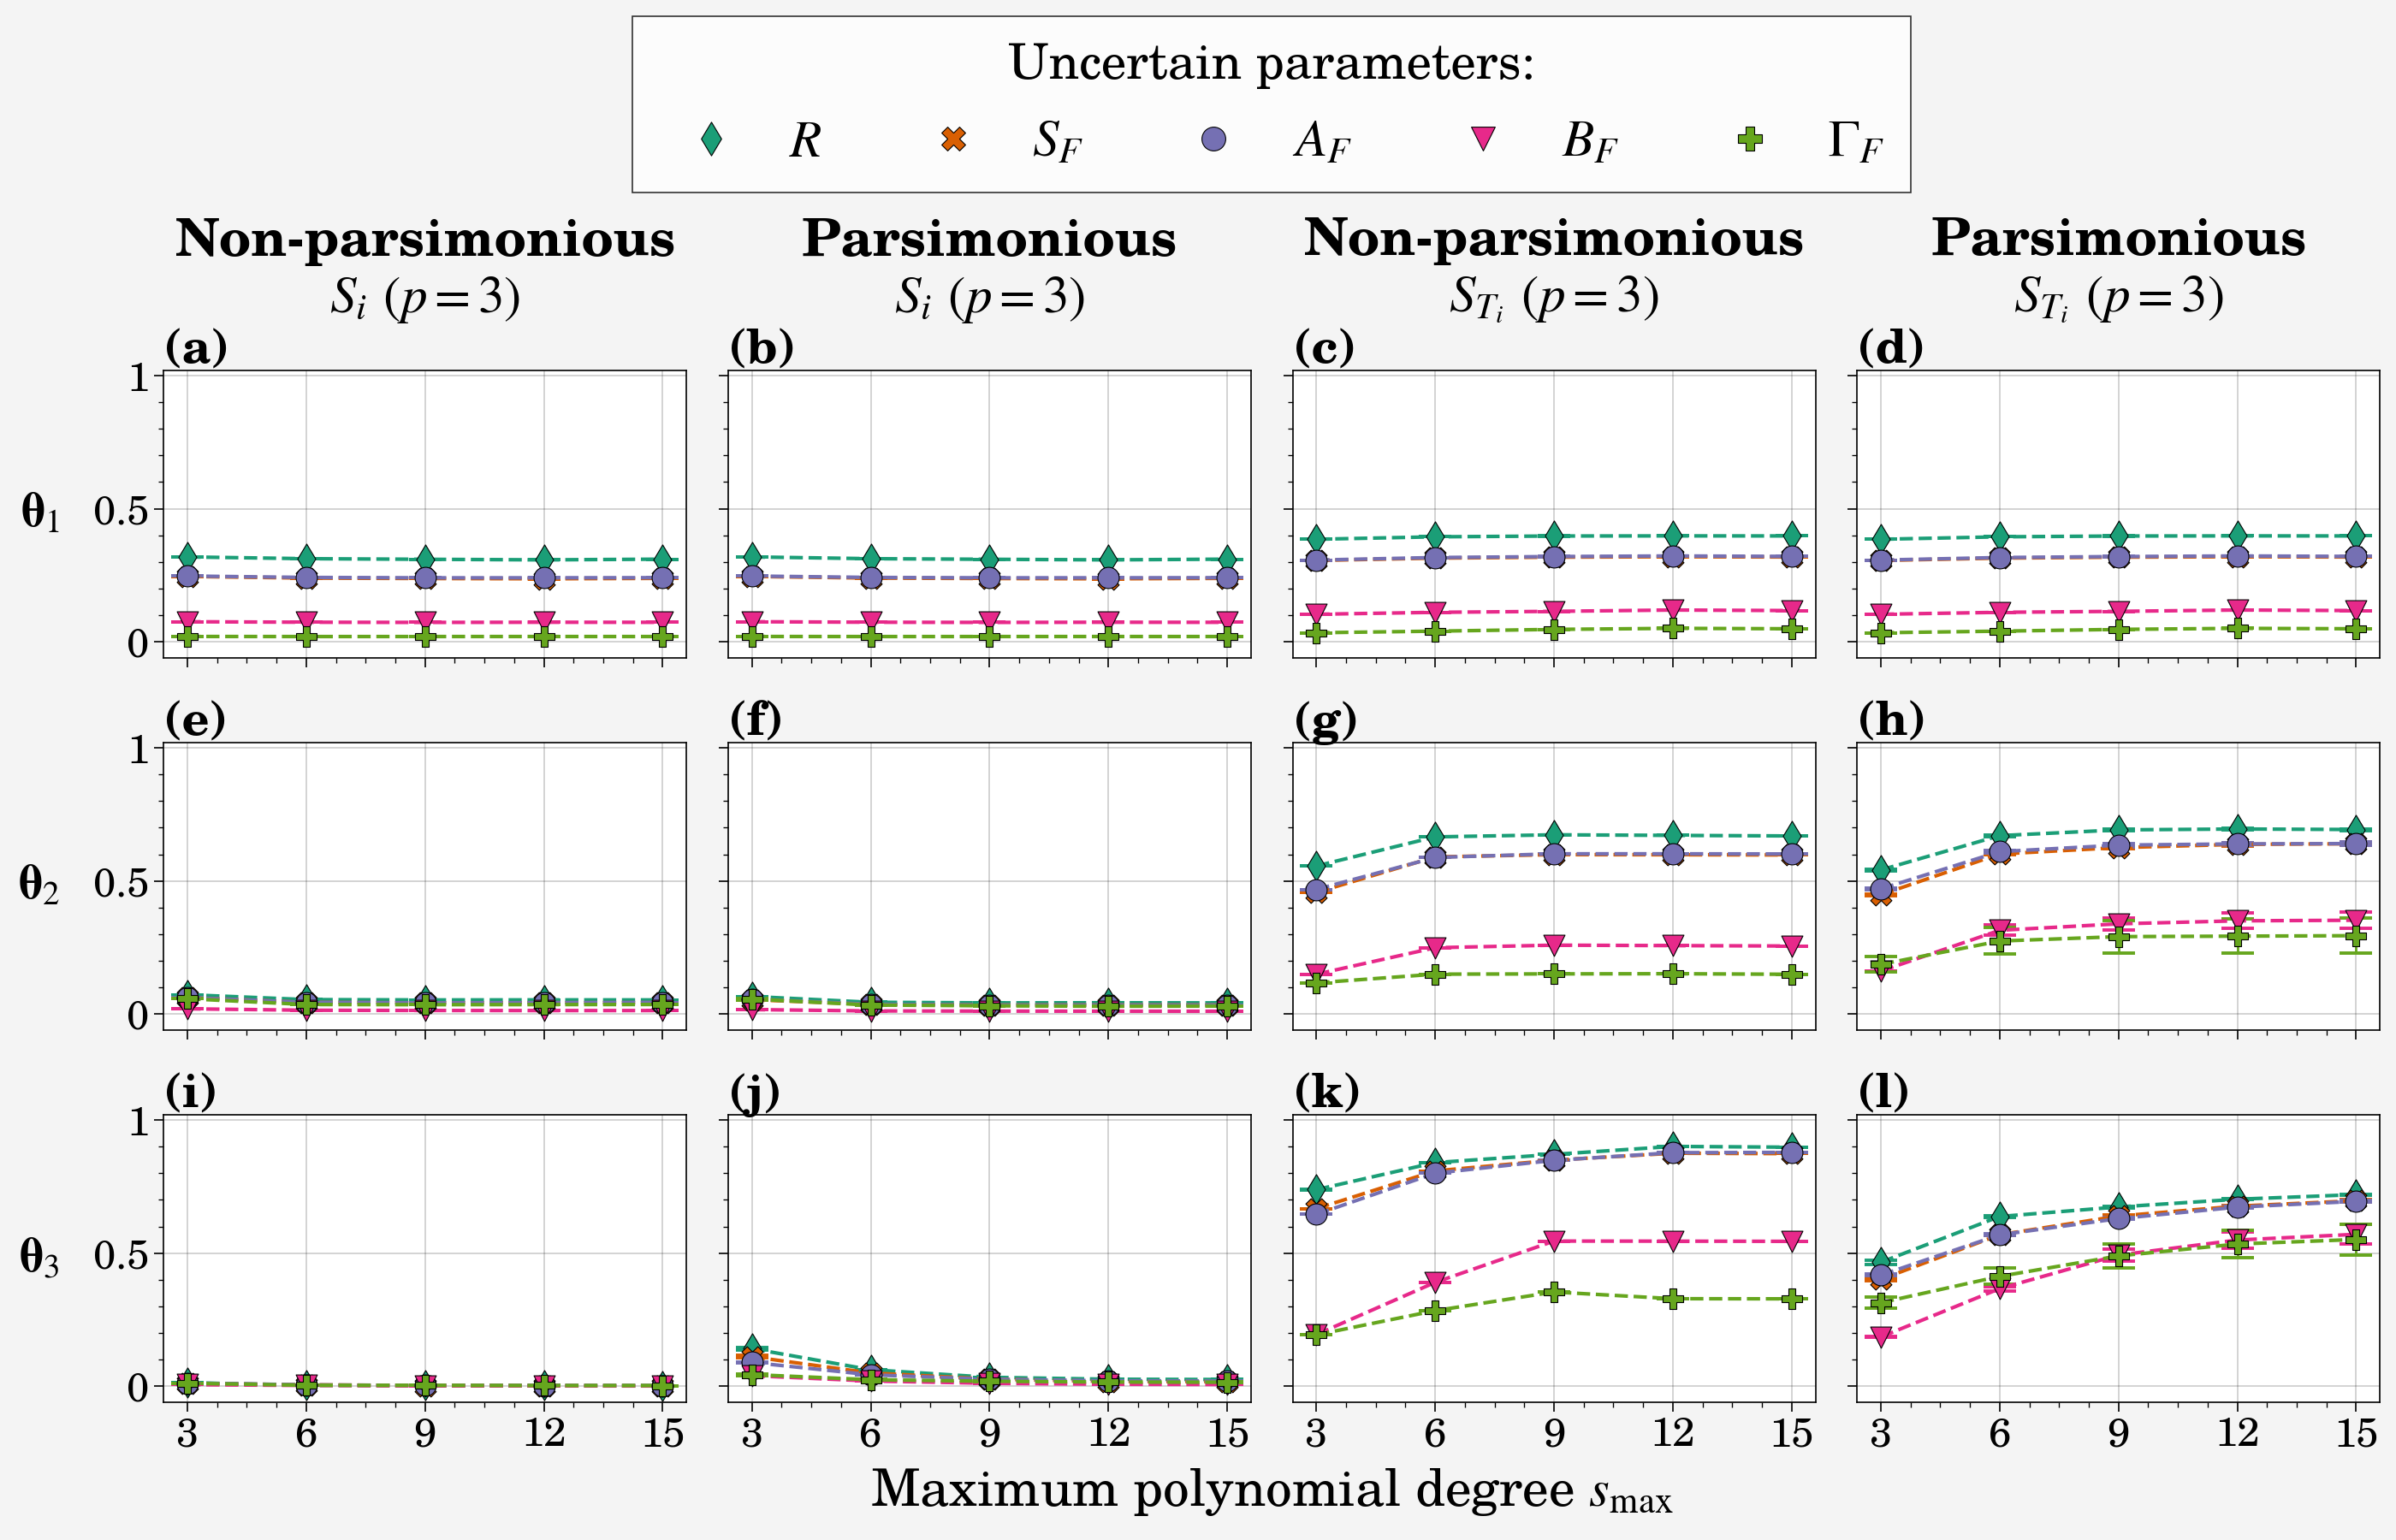

In [24]:
plot_GSA_diff_smax(SIs = [LAR_fo_si_nonparsim_p_3, LAR_fo_si_parsim_p_3,
                        LAR_to_si_nonparsim_p_3, LAR_to_si_parsim_p_3],
                 figsize = (14, 9),
                 suptitle = None,
                 legend_n_cols  = 5,
                 toplabels = ('Non-parsimonious\n'+r'$S_{i}$ $({p=3})$',
                              'Parsimonious\n'+r'$S_{i}$ $({p=3})$',
                              'Non-parsimonious\n'+r'$S_{T_i}$ $({p=3})$',
                              'Parsimonious\n'+r'$S_{T_i}$ $({p=3})$'),
                 title = "DeepABM_p3.pdf")

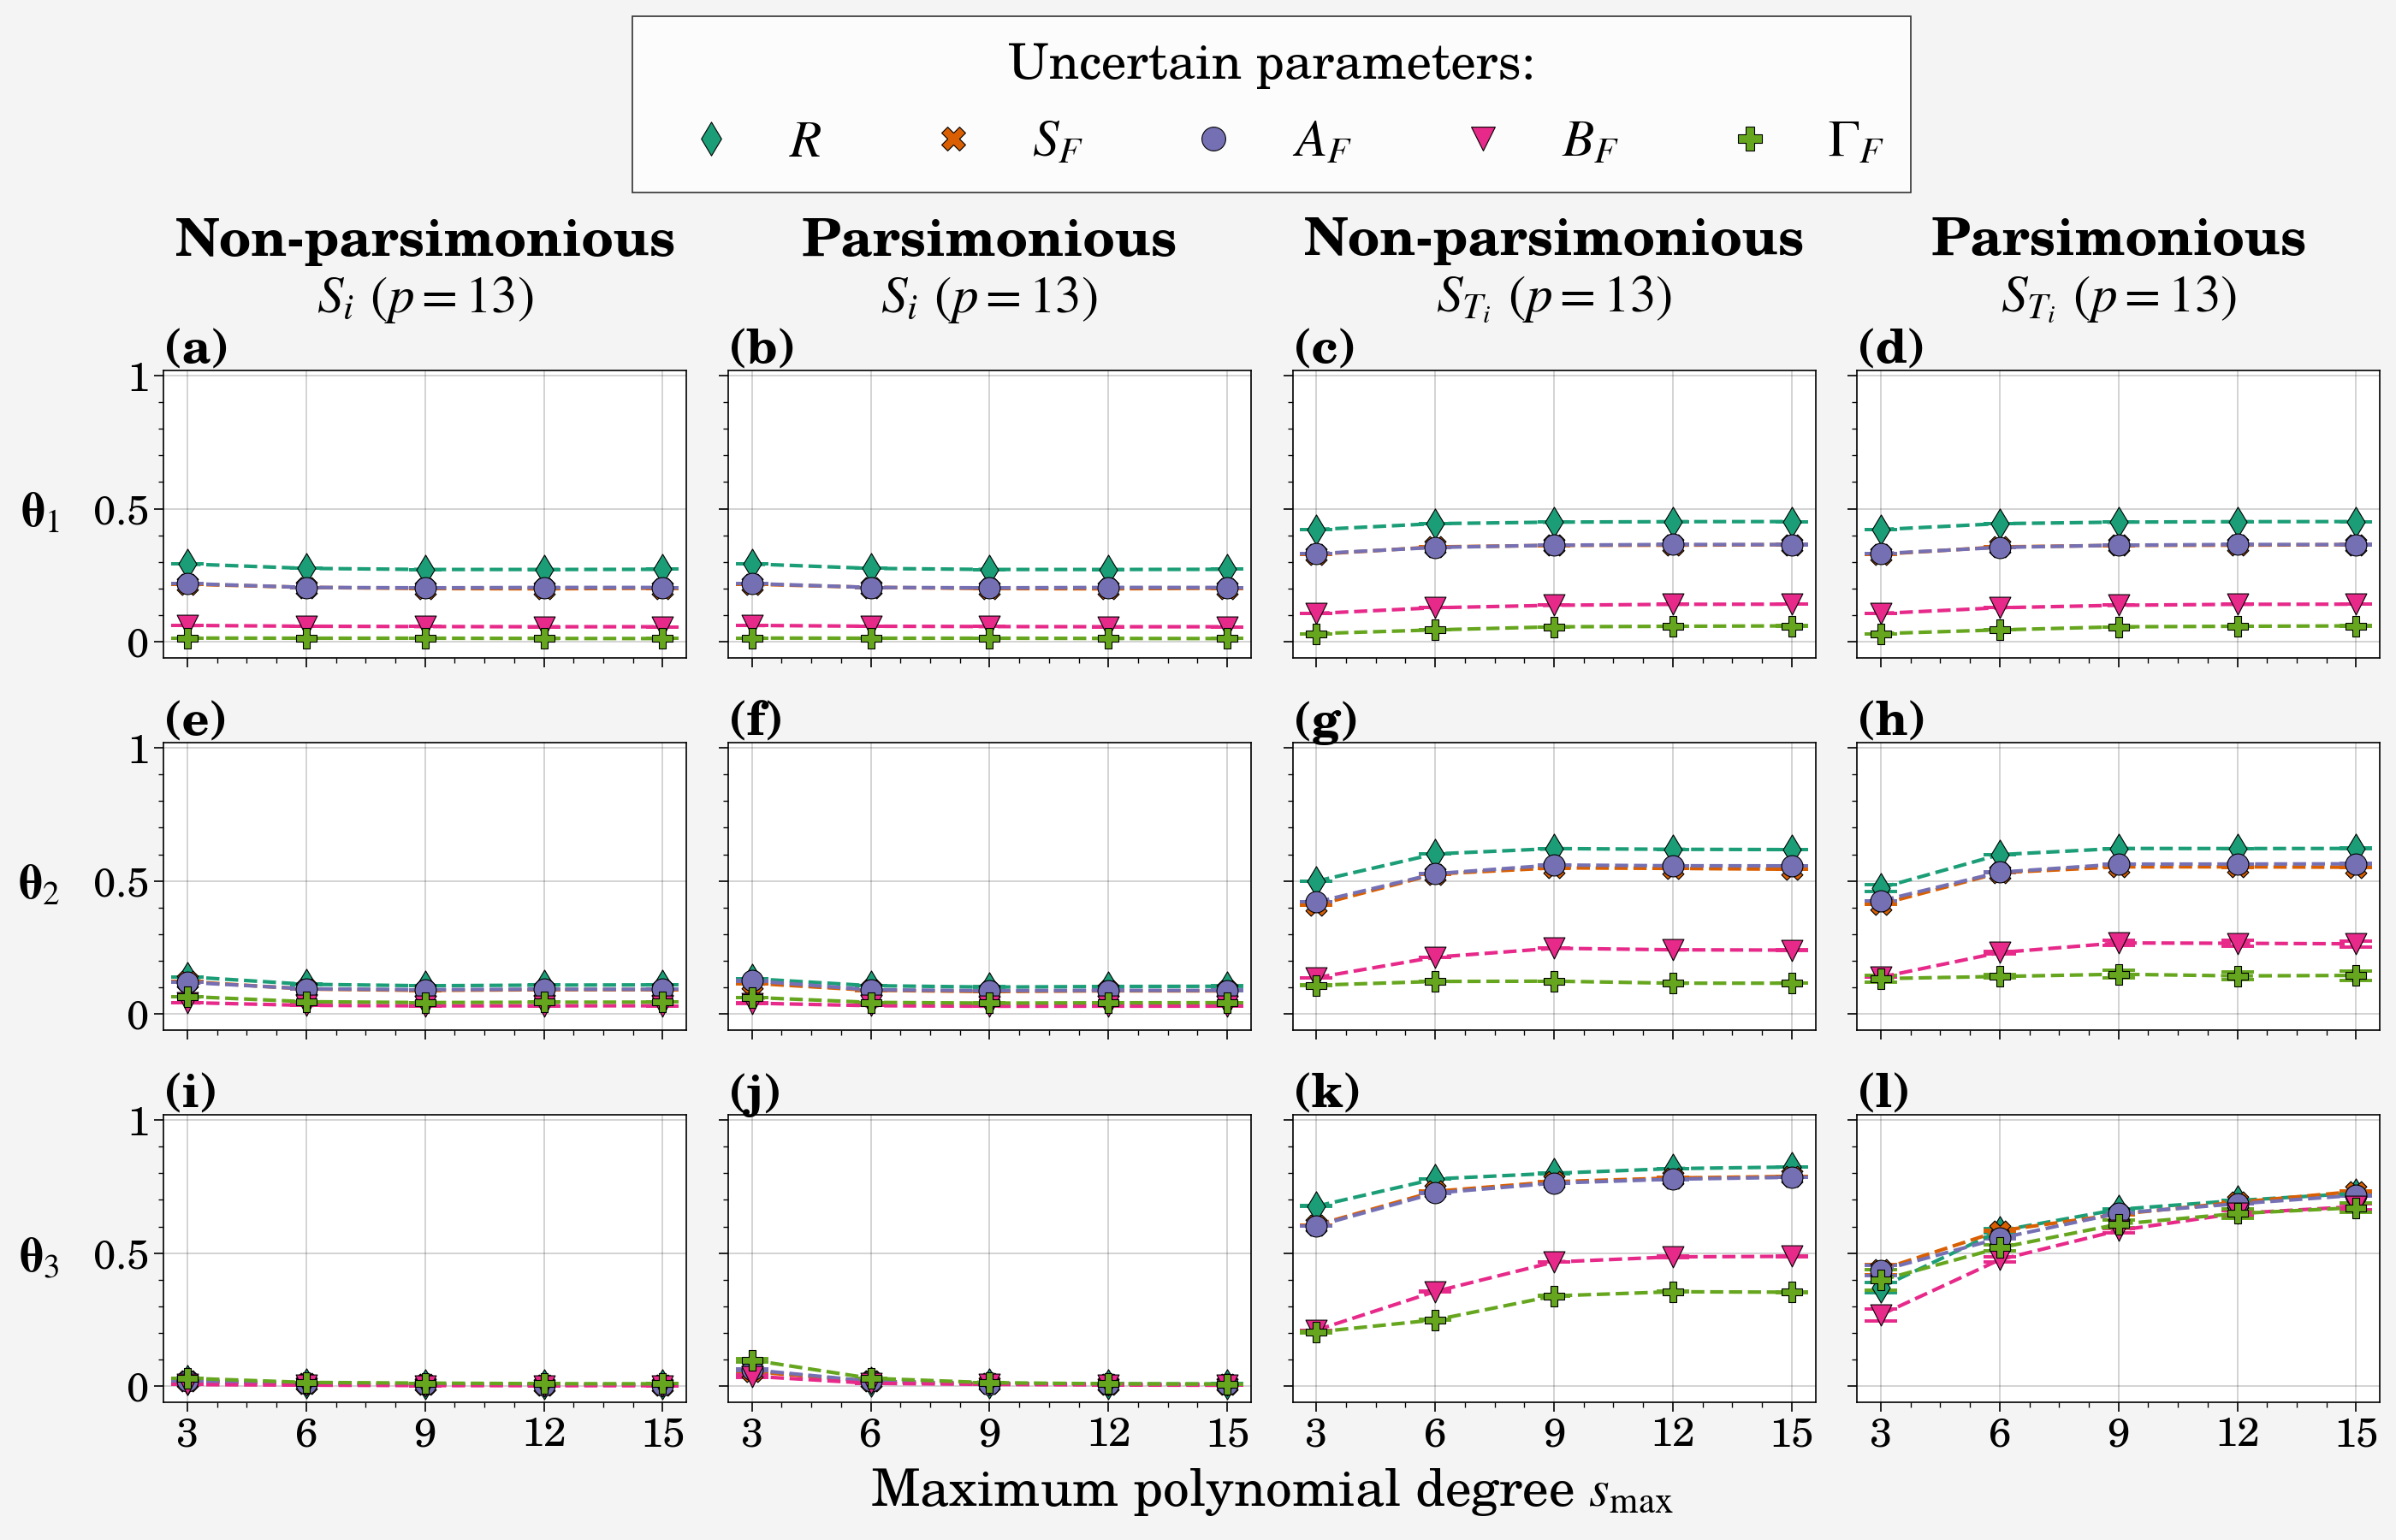

In [23]:
plot_GSA_diff_smax(SIs = [LAR_fo_si_nonparsim_p_13, LAR_fo_si_parsim_p_13,
                        LAR_to_si_nonparsim_p_13, LAR_to_si_parsim_p_13],
                 figsize = (14, 9),
                 suptitle = None,
                 legend_n_cols  = 5,
                 toplabels = ('Non-parsimonious\n'+r'$S_{i}$ $({p=13})$',
                              'Parsimonious\n'+r'$S_{i}$ $({p=13})$',
                              'Non-parsimonious\n'+r'$S_{T_i}$ $({p=13})$',
                              'Parsimonious\n'+r'$S_{T_i}$ $({p=13})$'),
                 title = "DeepABM_p13.pdf")

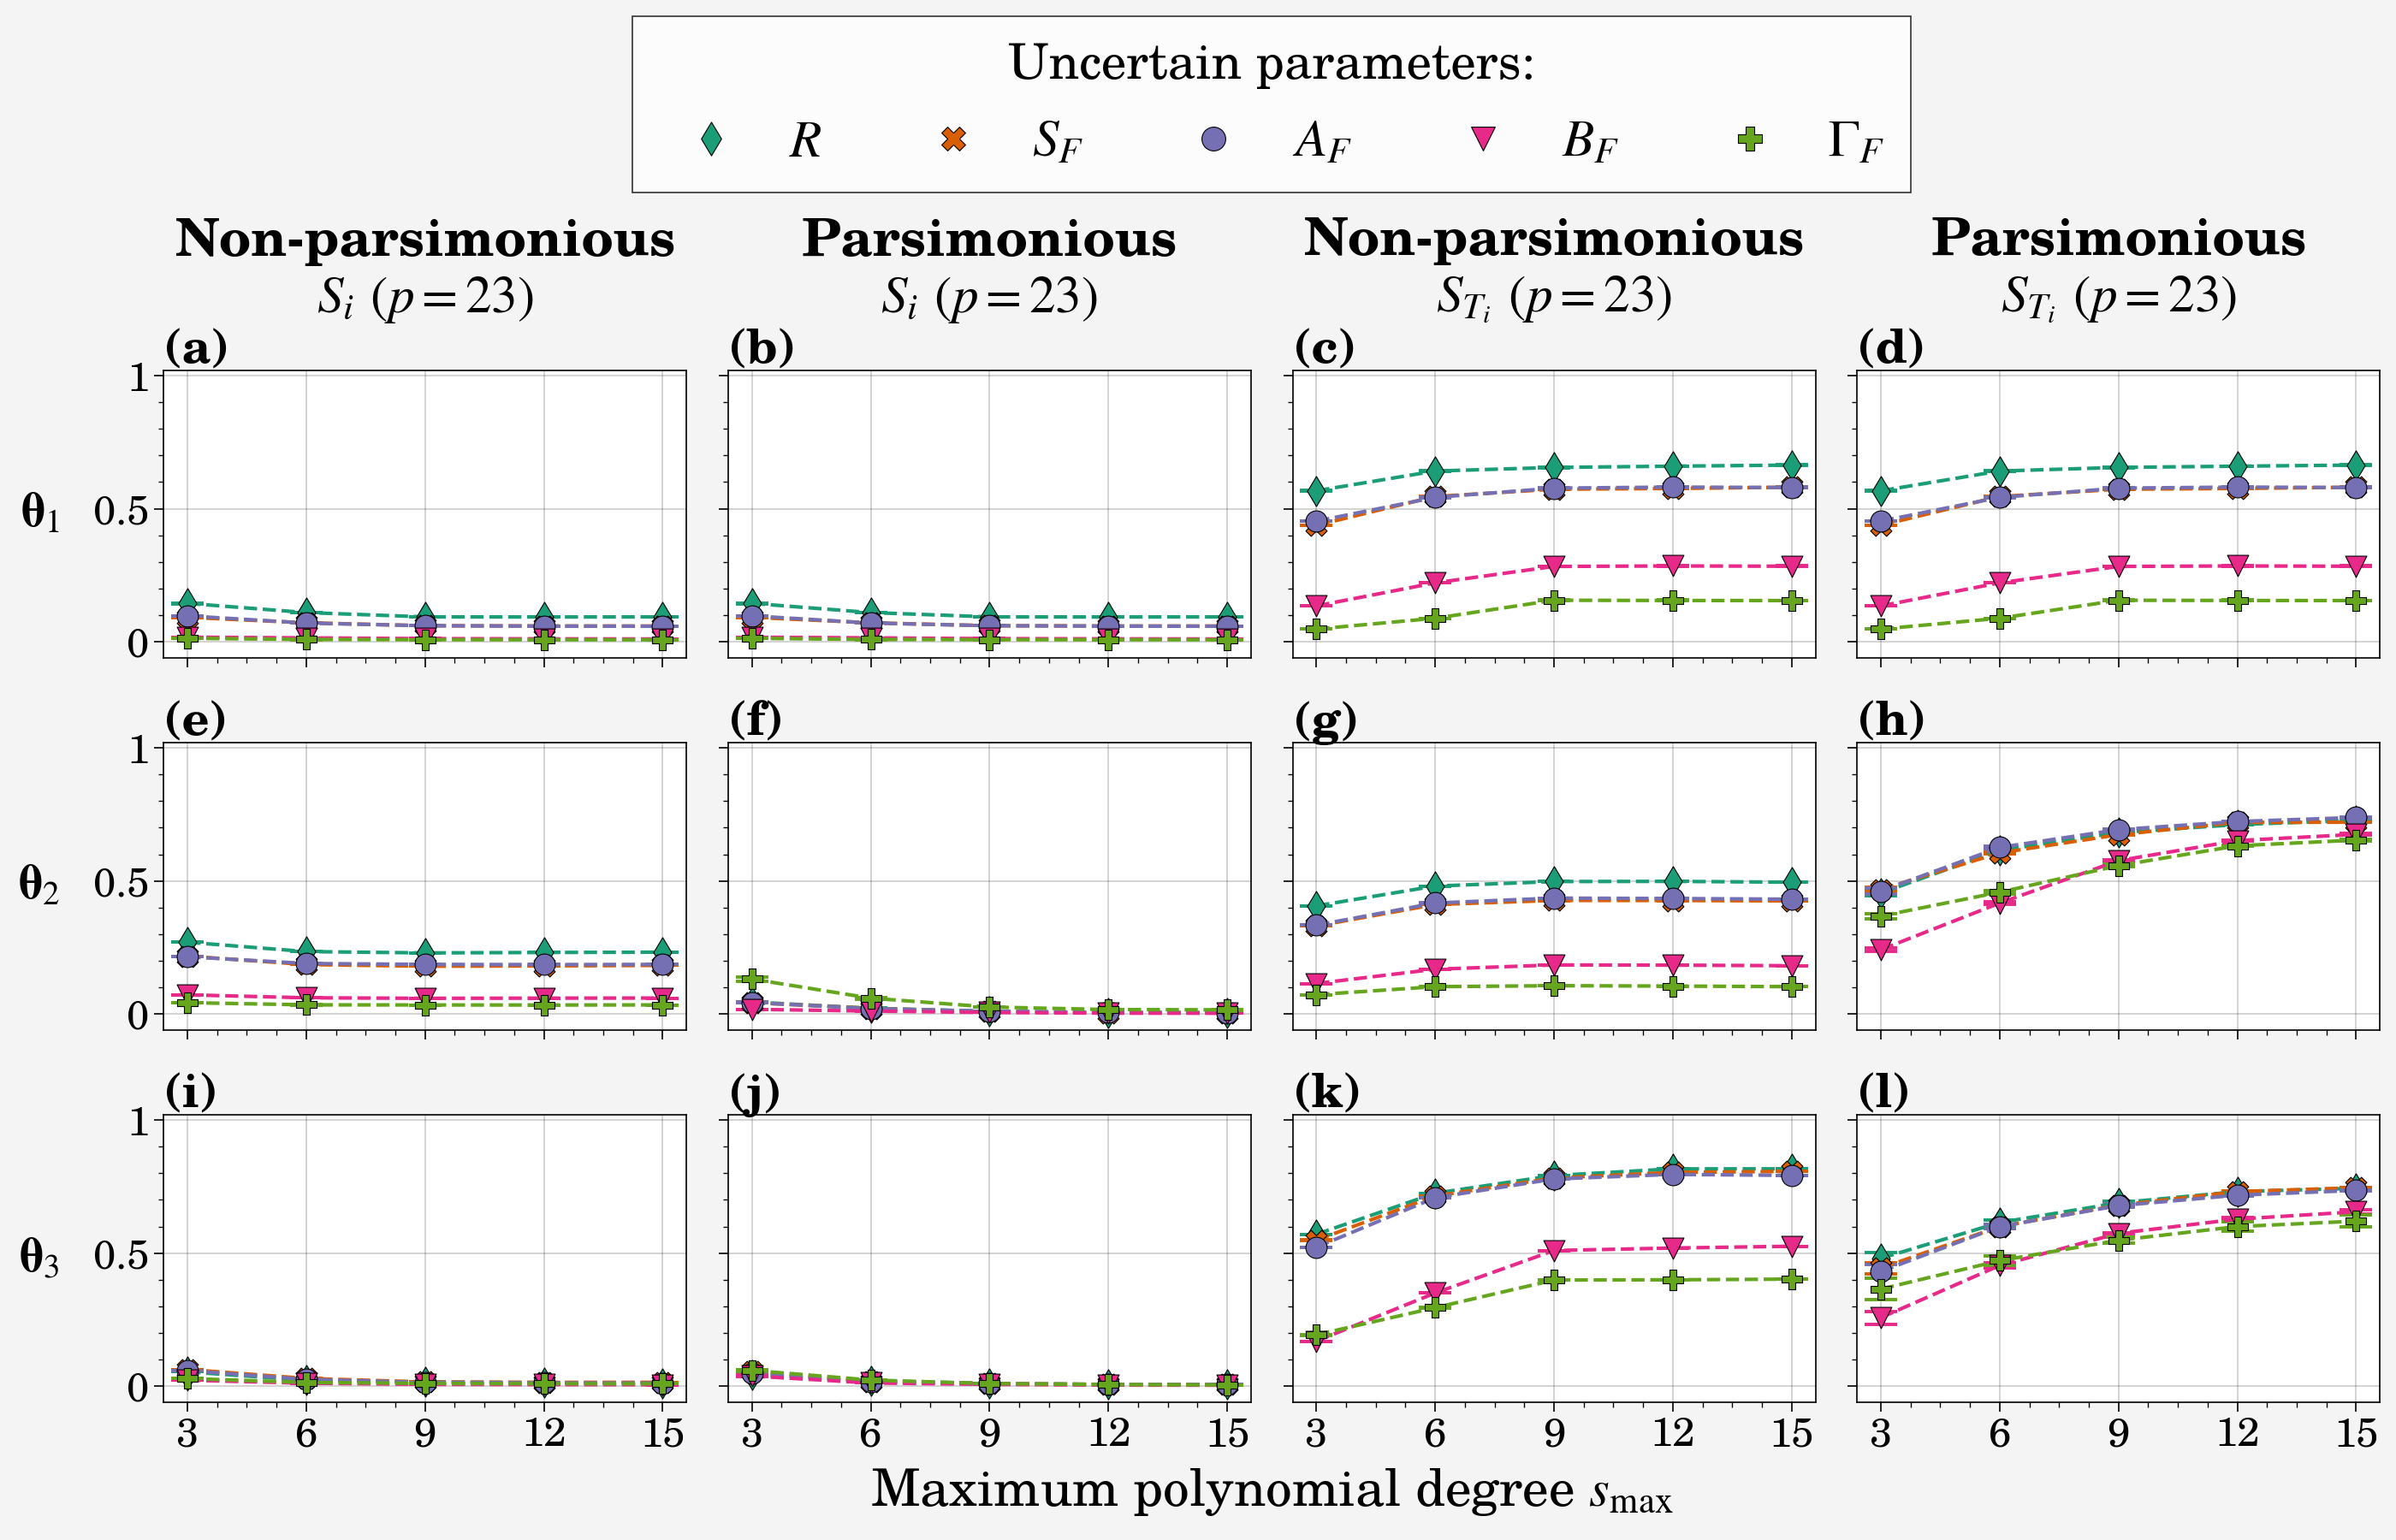

In [22]:
plot_GSA_diff_smax(SIs = [LAR_fo_si_nonparsim_p_23, LAR_fo_si_parsim_p_23,
                        LAR_to_si_nonparsim_p_23, LAR_to_si_parsim_p_23],
                 figsize = (14, 9),
                 suptitle = None,
                 legend_n_cols  = 5,
                 toplabels = ('Non-parsimonious\n'+r'$S_{i}$ $({p=23})$',
                              'Parsimonious\n'+r'$S_{i}$ $({p=23})$',
                              'Non-parsimonious\n'+r'$S_{T_i}$ $({p=23})$',
                              'Parsimonious\n'+r'$S_{T_i}$ $({p=23})$'),
                 title = "DeepABM_p23.pdf")

In [18]:
def plot_GSA_errors(errors, n_plot_cols, suptitle, figsize, legend_n_cols, 
                    toplabels, leftlabels, title, top=True):
    
#     dcoords = [r"$\mathbf{\theta}_1$", r"$\mathbf{\theta}_2$", r"$\mathbf{\theta}_3$"]
    dcoords = [r"First $\mathbf{\theta}$", r"Second $\mathbf{\theta}$", r"Third $\mathbf{\theta}$"]
    
    s_max = np.linspace(3, 15, 5, dtype='int')

    colors=mcp.gen_color(cmap="Dark2",n=7)
    marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
    
    fig, axs = pplt.subplots(ncols=n_plot_cols, nrows=3, figsize=figsize, sharex=True, sharey=False)
    
    for j, error in enumerate(errors):
        for i, d in enumerate(dcoords):
            
            axs[j].scatter(s_max, error.mean(axis=0)[:,i], label=dcoords[i],
                             color=colors[i], edgecolor="k", marker=marker_styles[i], 
                             markersize=100, linewidth=0.4, zorder=3)
            axs[j].errorbar(s_max, error.mean(axis=0)[:,i],
                              error.var(axis=0, ddof=1)[:,i],
                              markeredgewidth=1.4, color=colors[i],
                              linestyle='--', capsize=7, alpha=1, elinewidth=1) 
   
    axs.format(toplabels=toplabels,
               suptitle=suptitle,
               leftlabels=leftlabels,)

    for i, ax in enumerate(axs):
        ax.format(abc='(a)')
        ax.format(rc_kw={'suptitle.size': 22,
                         'suptitle.pad': 5.0,
                         'suptitle.color': "k",
                         'title.size': 22,
                         'abc.bboxpad': 10.0,
                         'abc.size': 20,
                         'label.size': 22,
                         'tick.labelsize': 17,
                         'leftlabel.size': 20,
                         'toplabel.size': 22,
                         'toplabel.pad': 5.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 10.0})
    
    ticks = s_max
    axs.set_xticks(ticks,
                  ['{}'.format(num) for num in ticks])
    
    axs.set_xlabel(r'Maximum polynomial degree $s_{\mathrm{max}}$', fontsize=22, labelpad=5)
    
    if top:
        lgnd = fig.legend(dcoords, ncols=legend_n_cols, frame=True, loc='t',
                          fontsize = 22, bbox_to_anchor=(0.5, 3),
                          title="Diffusion coordinates:", title_fontsize=21)
        
        for i in range(len(dcoords)):
            lgnd.legendHandles[i]._sizes = [100]
            
    for i, ax in enumerate(axs):
        ax.yaxis.label.set(rotation='horizontal', ha='right')

    fig.tight_layout()
    plt.savefig(f'plots/appendix/' + title, bbox_inches='tight')
    plt.show()

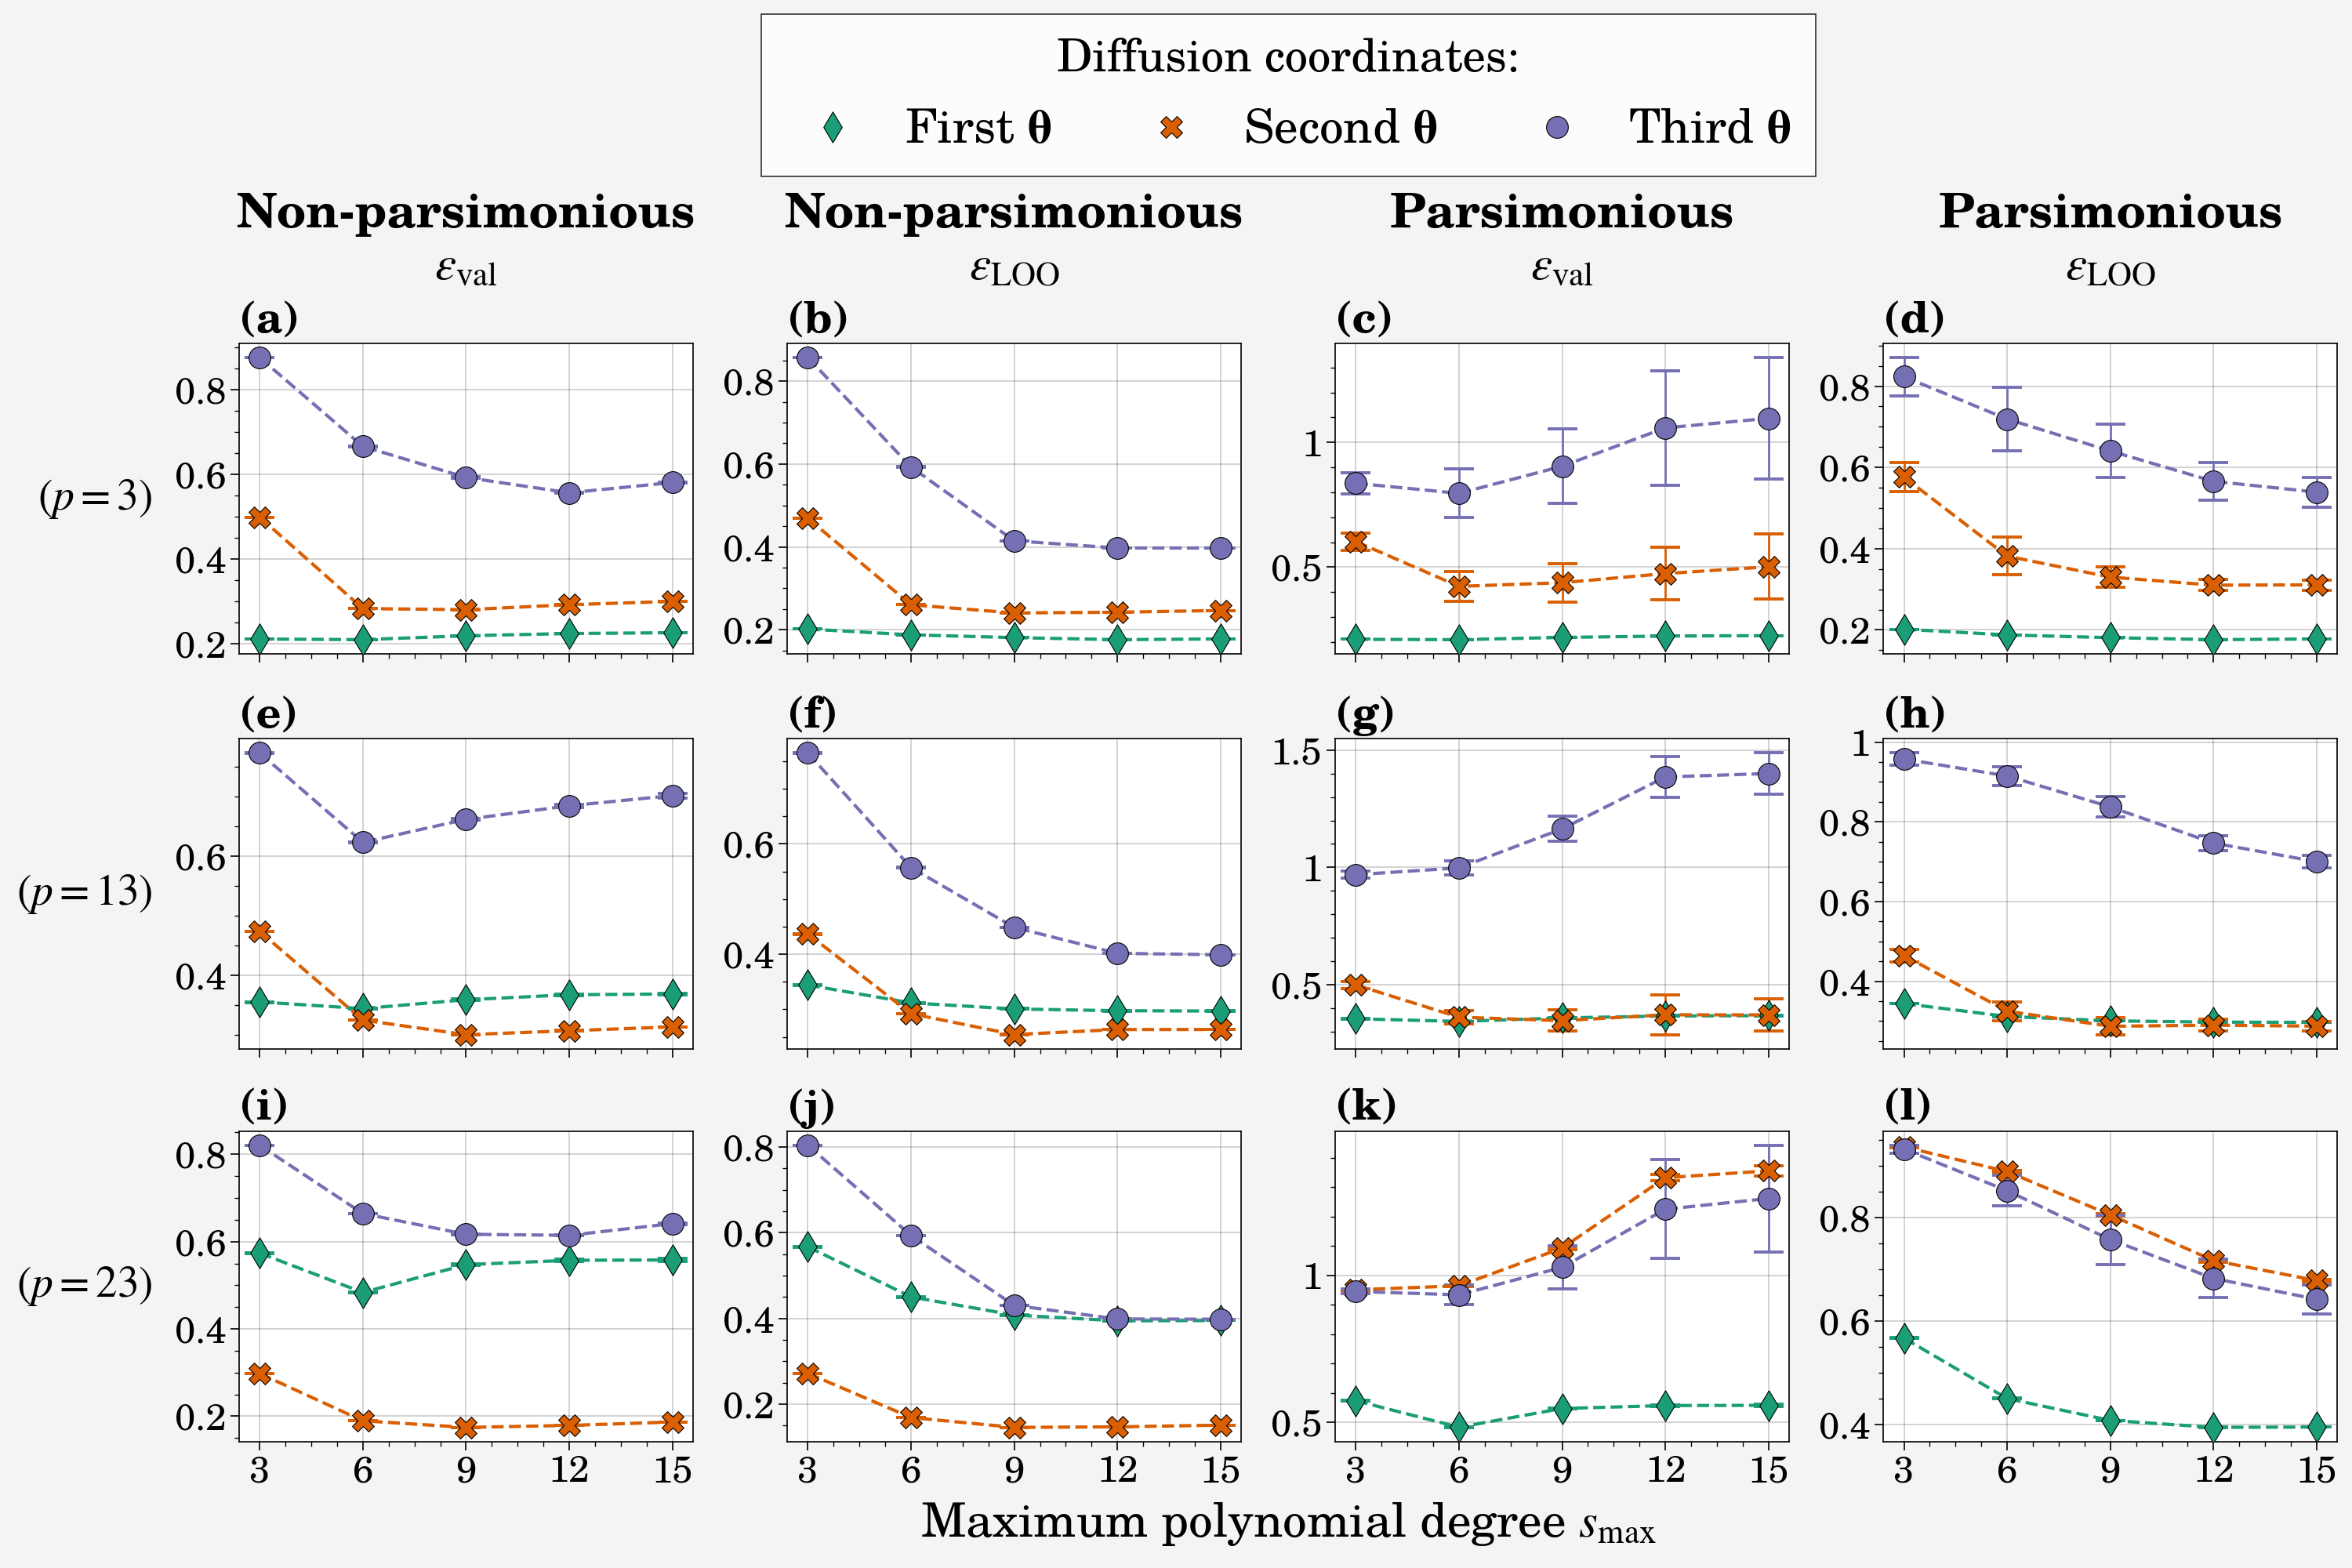

In [25]:
all_files = [
    'DeepABM_smax_3_24_nonparsim_p_3.npz',
    'DeepABM_smax_3_24_parsim_p_3.npz',
    'DeepABM_smax_3_24_nonparsim_p_13.npz',
    'DeepABM_smax_3_24_parsim_p_13.npz',
    'DeepABM_smax_3_24_nonparsim_p_23.npz',
    'DeepABM_smax_3_24_parsim_p_23.npz',
]


LAR_errors = []

for f in all_files:
    
    GSA_res = np.load(PATH + f'PCE_GSA/' + f, allow_pickle=True)

    LAR_error     = GSA_res['x7']
    LAR_LOO       = GSA_res['x8']  
    
    LAR_errors.append(LAR_error)
    LAR_errors.append(LAR_LOO)


plot_GSA_errors(errors = LAR_errors, 
                n_plot_cols = 4,
                suptitle = None, 
                figsize = (15, 10),
                legend_n_cols = 3, 
                toplabels = ('Non-parsimonious\n'+r'$\epsilon_{\mathrm{val}}$',
                             'Non-parsimonious\n'+r'$\epsilon_{\mathrm{LOO}}$',
                             'Parsimonious\n'+r'$\epsilon_{\mathrm{val}}$',
                             'Parsimonious\n'+r'$\epsilon_{\mathrm{LOO}}$'),
                leftlabels=[r"$(p=3)$", r"$(p=13)$", r"$(p=23)$"], 
                title = "DeepABM_LAR_errors_all.pdf", 
                top=True)
    

In [11]:
p_array = [3, 13, 23]

np_pce_total_Si_mean_p = {}
np_pce_first_Si_mean_p = {}
np_pce_total_Si_var_p = {}
np_pce_first_Si_var_p = {}

parsim_pce_first_Si_mean_p = {}
parsim_pce_total_Si_mean_p = {}
parsim_pce_first_Si_var_p = {}
parsim_pce_total_Si_var_p = {}

for p in p_array:
    file_parsim = np.load(PATH + f'PCE_GSA/DeepABM_smax_3_24_parsim_p_{p}.npz', 
                       allow_pickle=True)
    
    LAR_fo_parsim = file_parsim['x5']
    LAR_to_parsim = file_parsim['x6']

    parsim_pce_first_Si_mean_p[p] = LAR_fo_parsim.mean(axis=0)
    parsim_pce_total_Si_mean_p[p] = LAR_to_parsim.mean(axis=0)
    
    parsim_pce_first_Si_var_p[p] = LAR_fo_parsim.var(axis=0, ddof=1)
    parsim_pce_total_Si_var_p[p] = LAR_to_parsim.var(axis=0, ddof=1)
    
    
    file_nonparsim = np.load(PATH + f'PCE_GSA/DeepABM_smax_3_24_nonparsim_p_{p}.npz', 
                       allow_pickle=True)
    
    LAR_fo_nonparsim = file_nonparsim['x5']
    LAR_to_nonparsim = file_nonparsim['x6']
    
    np_pce_first_Si_mean_p[p] = LAR_fo_nonparsim.mean(axis=0)
    np_pce_total_Si_mean_p[p] = LAR_to_nonparsim.mean(axis=0)
    
    np_pce_first_Si_var_p[p] = LAR_fo_nonparsim.var(axis=0, ddof=1)
    np_pce_total_Si_var_p[p] = LAR_to_nonparsim.var(axis=0, ddof=1)
    

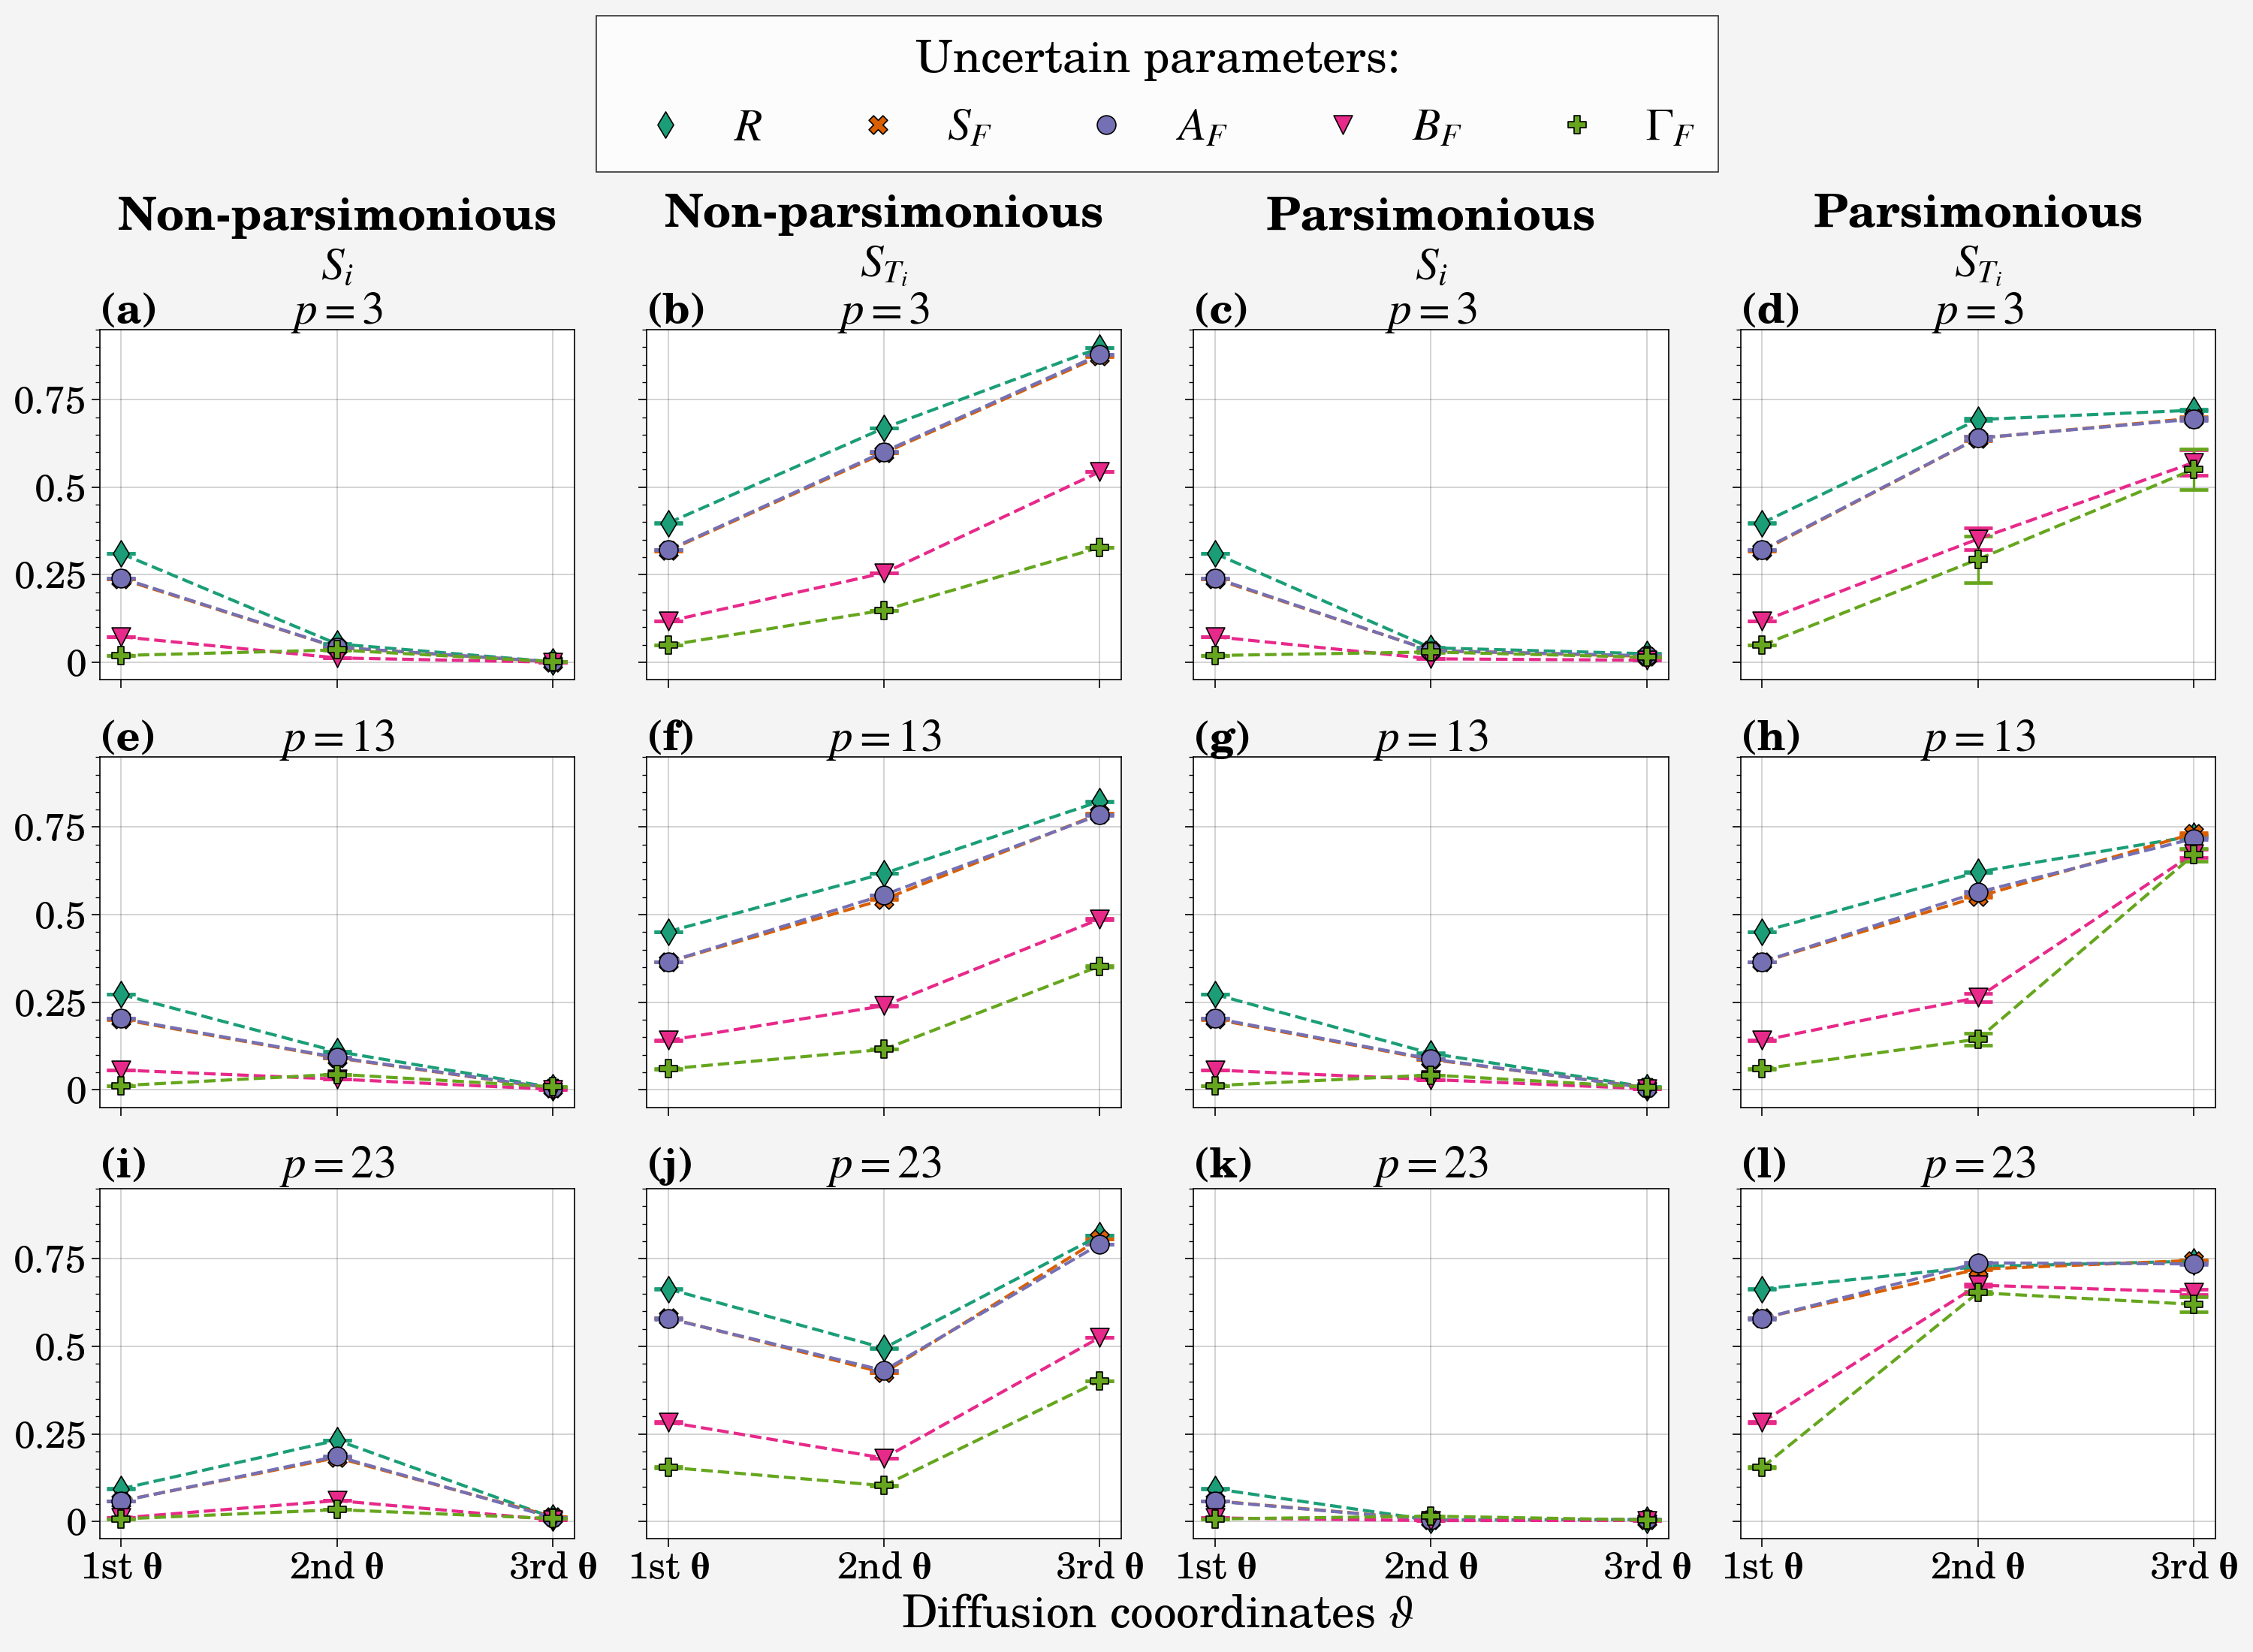

In [16]:
pplt.rc['axes.labelsize'] = 17

fig, axs = pplt.subplots(ncols=4, nrows=3, figsize=(15, 11), sharex=True, sharey=True)

col1 = np.linspace(0, 12, 4, dtype='int')
col2 = np.linspace(1, 13, 4, dtype='int')
col3 = np.linspace(2, 14, 4, dtype='int')
col4 = np.linspace(3, 15, 4, dtype='int')

error_marker_styles = ['d', 'X','o', 'v', 'P', 's', '*']
colors=mcp.gen_color(cmap="Dark2",n=9)

param_names = list(param_names_short.values())

for p_ind, p in enumerate(p_array):
    for i, param in enumerate(param_names_short.values()):
        
        
        axs[col1[p_ind]].scatter(np.linspace(1, 3, 3, dtype='int'), 
                                 np_pce_first_Si_mean_p[p][-1][i], color=colors[i],
                                 edgecolor='k', label=param_names[i],
                                 marker=error_marker_styles[i], 
                                 markersize=80, zorder=3)   
        axs[col1[p_ind]].errorbar(np.linspace(1, 3, 3, dtype='int'), 
                                  np_pce_first_Si_mean_p[p][-1][i], 
                                  np_pce_first_Si_var_p[p][-1][i], 
                                  color=colors[i],
                                  markeredgewidth=1.7, 
                                  linestyle='--', capsize=7, alpha=1, elinewidth=1.2) 
        axs[col1[p_ind]].format(ylim=(-0.05, 1.05))
        axs[col1[p_ind]].format(title=r'$p={}$'.format(p))
        
        axs[col2[p_ind]].scatter(np.linspace(1, 3, 3, dtype='int'), 
                                 np_pce_total_Si_mean_p[p][-1][i], color=colors[i],
                                 edgecolor='k', 
                                 marker=error_marker_styles[i], 
                                 markersize=80, zorder=3)   
        axs[col2[p_ind]].errorbar(np.linspace(1, 3, 3, dtype='int'), 
                                  np_pce_total_Si_mean_p[p][-1][i], 
                                  np_pce_total_Si_var_p[p][-1][i], 
                                  color=colors[i],
                                  markeredgewidth=1.7, 
                                  linestyle='--', capsize=7, alpha=1, elinewidth=1.2) 
        axs[col2[p_ind]].format(ylim=(-0.05, 1.05))
        axs[col2[p_ind]].format(title=r'$p={}$'.format(p))
        
        axs[col3[p_ind]].scatter(np.linspace(1, 3, 3, dtype='int'), 
                                 parsim_pce_first_Si_mean_p[p][-1][i], color=colors[i],
                                 edgecolor='k', 
                                 marker=error_marker_styles[i], 
                                 markersize=80, zorder=3)   
        axs[col3[p_ind]].errorbar(np.linspace(1, 3, 3, dtype='int'), 
                                  parsim_pce_first_Si_mean_p[p][-1][i], 
                                  parsim_pce_first_Si_var_p[p][-1][i],  
                                  color=colors[i],
                                  markeredgewidth=1.7, 
                                  linestyle='--', capsize=7, alpha=1, elinewidth=1.2) 
        axs[col3[p_ind]].format(ylim=(-0.05, 1.05))
        axs[col3[p_ind]].format(title=r'$p={}$'.format(p))
                                
        axs[col4[p_ind]].scatter(np.linspace(1, 3, 3, dtype='int'), 
                                 parsim_pce_total_Si_mean_p[p][-1][i], color=colors[i],
                                 edgecolor='k', 
                                 marker=error_marker_styles[i], 
                                 markersize=80, zorder=3)   
        axs[col4[p_ind]].errorbar(np.linspace(1, 3, 3, dtype='int'), 
                                  parsim_pce_total_Si_mean_p[p][-1][i], 
                                  parsim_pce_total_Si_var_p[p][-1][i],  
                                  color=colors[i],
                                  markeredgewidth=1.7,
                                  linestyle='--', capsize=7, alpha=1, elinewidth=1.2) 
        axs[col4[p_ind]].format(ylim=(-0.05, 0.95))
        axs[col4[p_ind]].format(title=r'$p={}$'.format(p))
         
    for ax in axs:
        ax.format(abc='(a)', xlabel=r'Diffusion cooordinates $\vartheta$', 
                  xticklabels=['0', '1st '+r"$\mathbf{\theta}$", 
                               '2nd '+r"$\mathbf{\theta}$",  
                               '3rd '+r"$\mathbf{\theta}$"])
        ax.format(rc_kw={'suptitle.size': 22,
                         'suptitle.pad': 5.0,
                         'suptitle.color': "k",
                         'title.size': 22,
                         'abc.size': 20,
                         'title.pad': 3.0,
                         'label.size': 22,
                         'tick.labelsize': 18,
                         'leftlabel.size': 20,
                         'toplabel.size': 22,
                         'toplabel.pad': 1.0,
                         'leftlabel.rotation': "horizontal",
                         'leftlabel.pad': 14.0})
        
axs.format(toplabels=('Non-parsimonious\n' + r'$S_i$', 
                      'Non-parsimonious\n' + r'$S_{T_i}$',
                      'Parsimonious\n' + r'$S_i$', 
                      'Parsimonious\n'+ r'$S_{T_i}$'))

fig.legend(param_names, ncols=5, frame=True, loc='t',
           fontsize = 22, bbox_to_anchor=(0.5, 3),
           title="Uncertain parameters:", title_fontsize=22)

fig.tight_layout()
plt.savefig('plots/main_text/DeepABM_GDMaps_PCE_GSA.pdf', bbox_inches='tight')
plt.show()       

# Plots from the paper (main text) and SI using the written data

In [27]:
GDMaps_PATH = 'data/data_DeepABM/GSA_results/GDMaps'

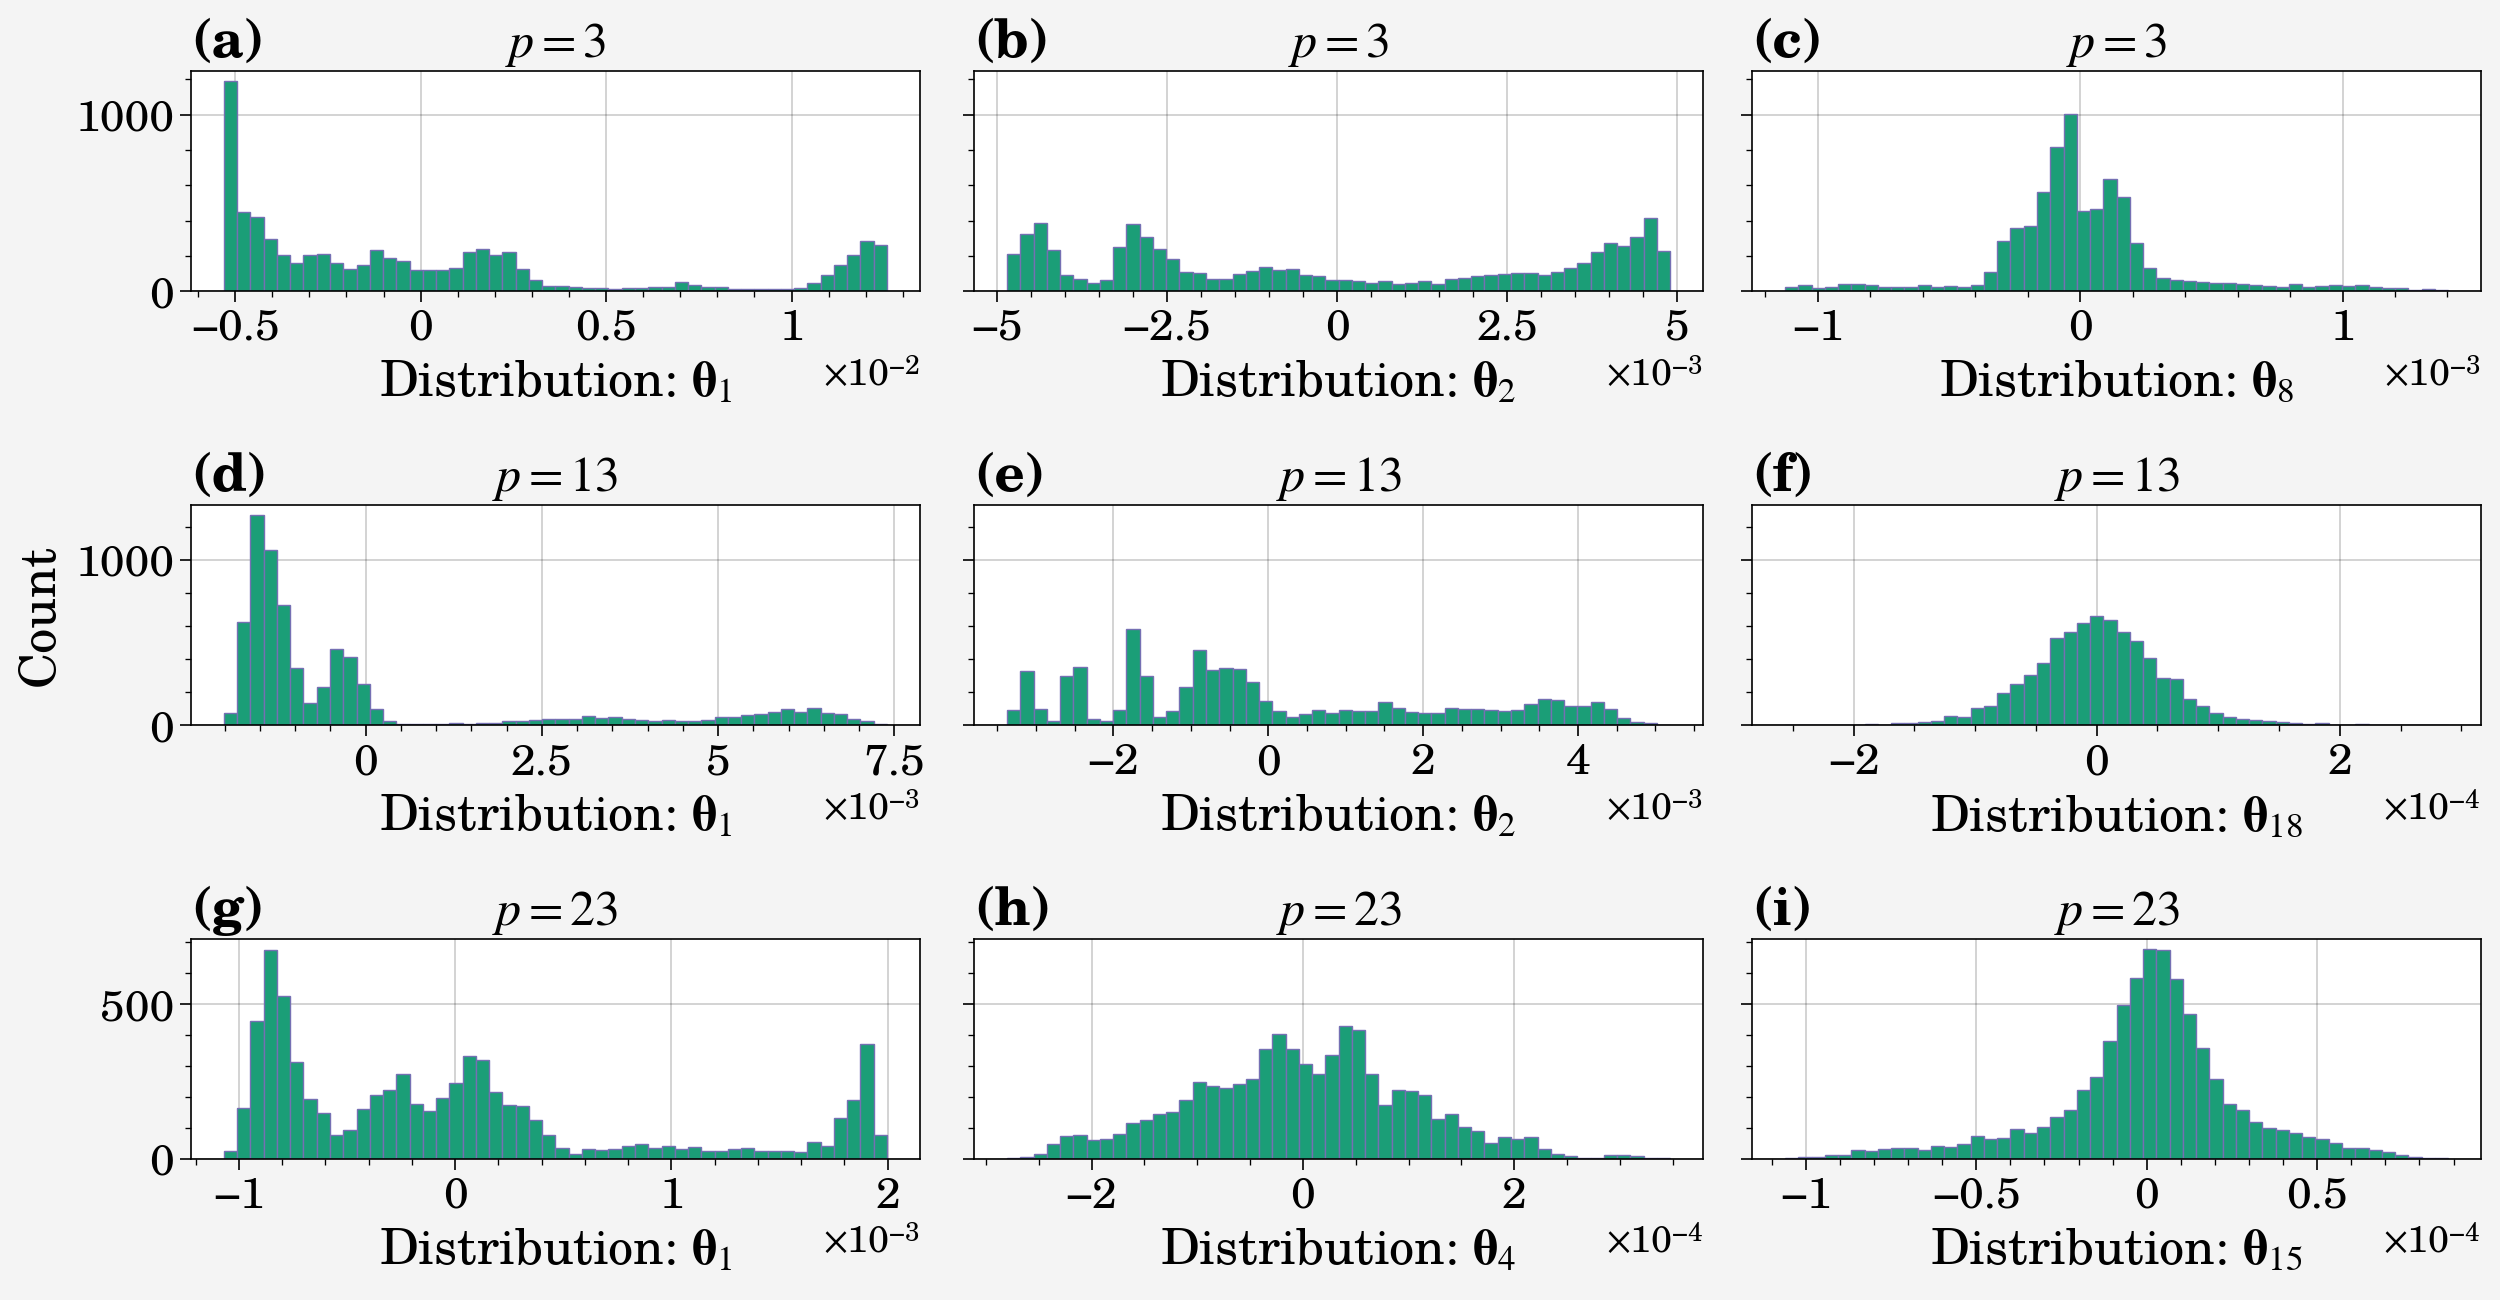

In [29]:
run = 17

pplt.rc['axes.labelsize'] = 16

fig, axs = pplt.subplots(ncols=3, nrows=3, figsize=(12.5, 6.5), sharex=False, sharey=True)

for p_i, p in enumerate([3, 13, 23]):

    file_res = np.load(GDMaps_PATH+f'/DeepABM_parsim_20_runs_p_{p}.npz', 
                       allow_pickle=True)
    
    evals_diff_runs = file_res['x1'] 
    evecs_diff_runs = file_res['x2'] 
    coord_diff_runs = file_res['x3']
    g_diff_runs = file_res['x4']    
    residuals_diff_runs = file_res['x5'] 
    index_diff_runs = file_res['x6']    


    for coord_i, coord_n in enumerate(coord_diff_runs[run]):
        axs[p_i*3+coord_i].hist(g_diff_runs[run][:, coord_i], bins=50, 
                          facecolor = '#1b9e77', edgecolor='#7570b3', linewidth=0.5)
        axs[p_i*3+coord_i].format(abc='(a)', 
                                  xlabel='Distribution: ' + r'$\mathbf{\theta}$'+r'$_{{{}}}$'.format(coord_n), 
                                  ylabel=r'Count', title=r'$p={{{}}}$'.format(p), titlesize=17)
        
    for ax in axs:
        ax.ticklabel_format(style="scientific", scilimits=(-2, -3), axis='x')
        ax.format(rc_kw={'title.size': 18,
                         'label.size': 18,
                         'tick.labelsize': 16,
                         'leftlabel.size': 17.5,
                         'abc.size': 19})
        
fig.tight_layout()
plt.savefig(f'plots/appendix/run{run}_coord_dist_diff_p.pdf', bbox_inches='tight')
plt.show()


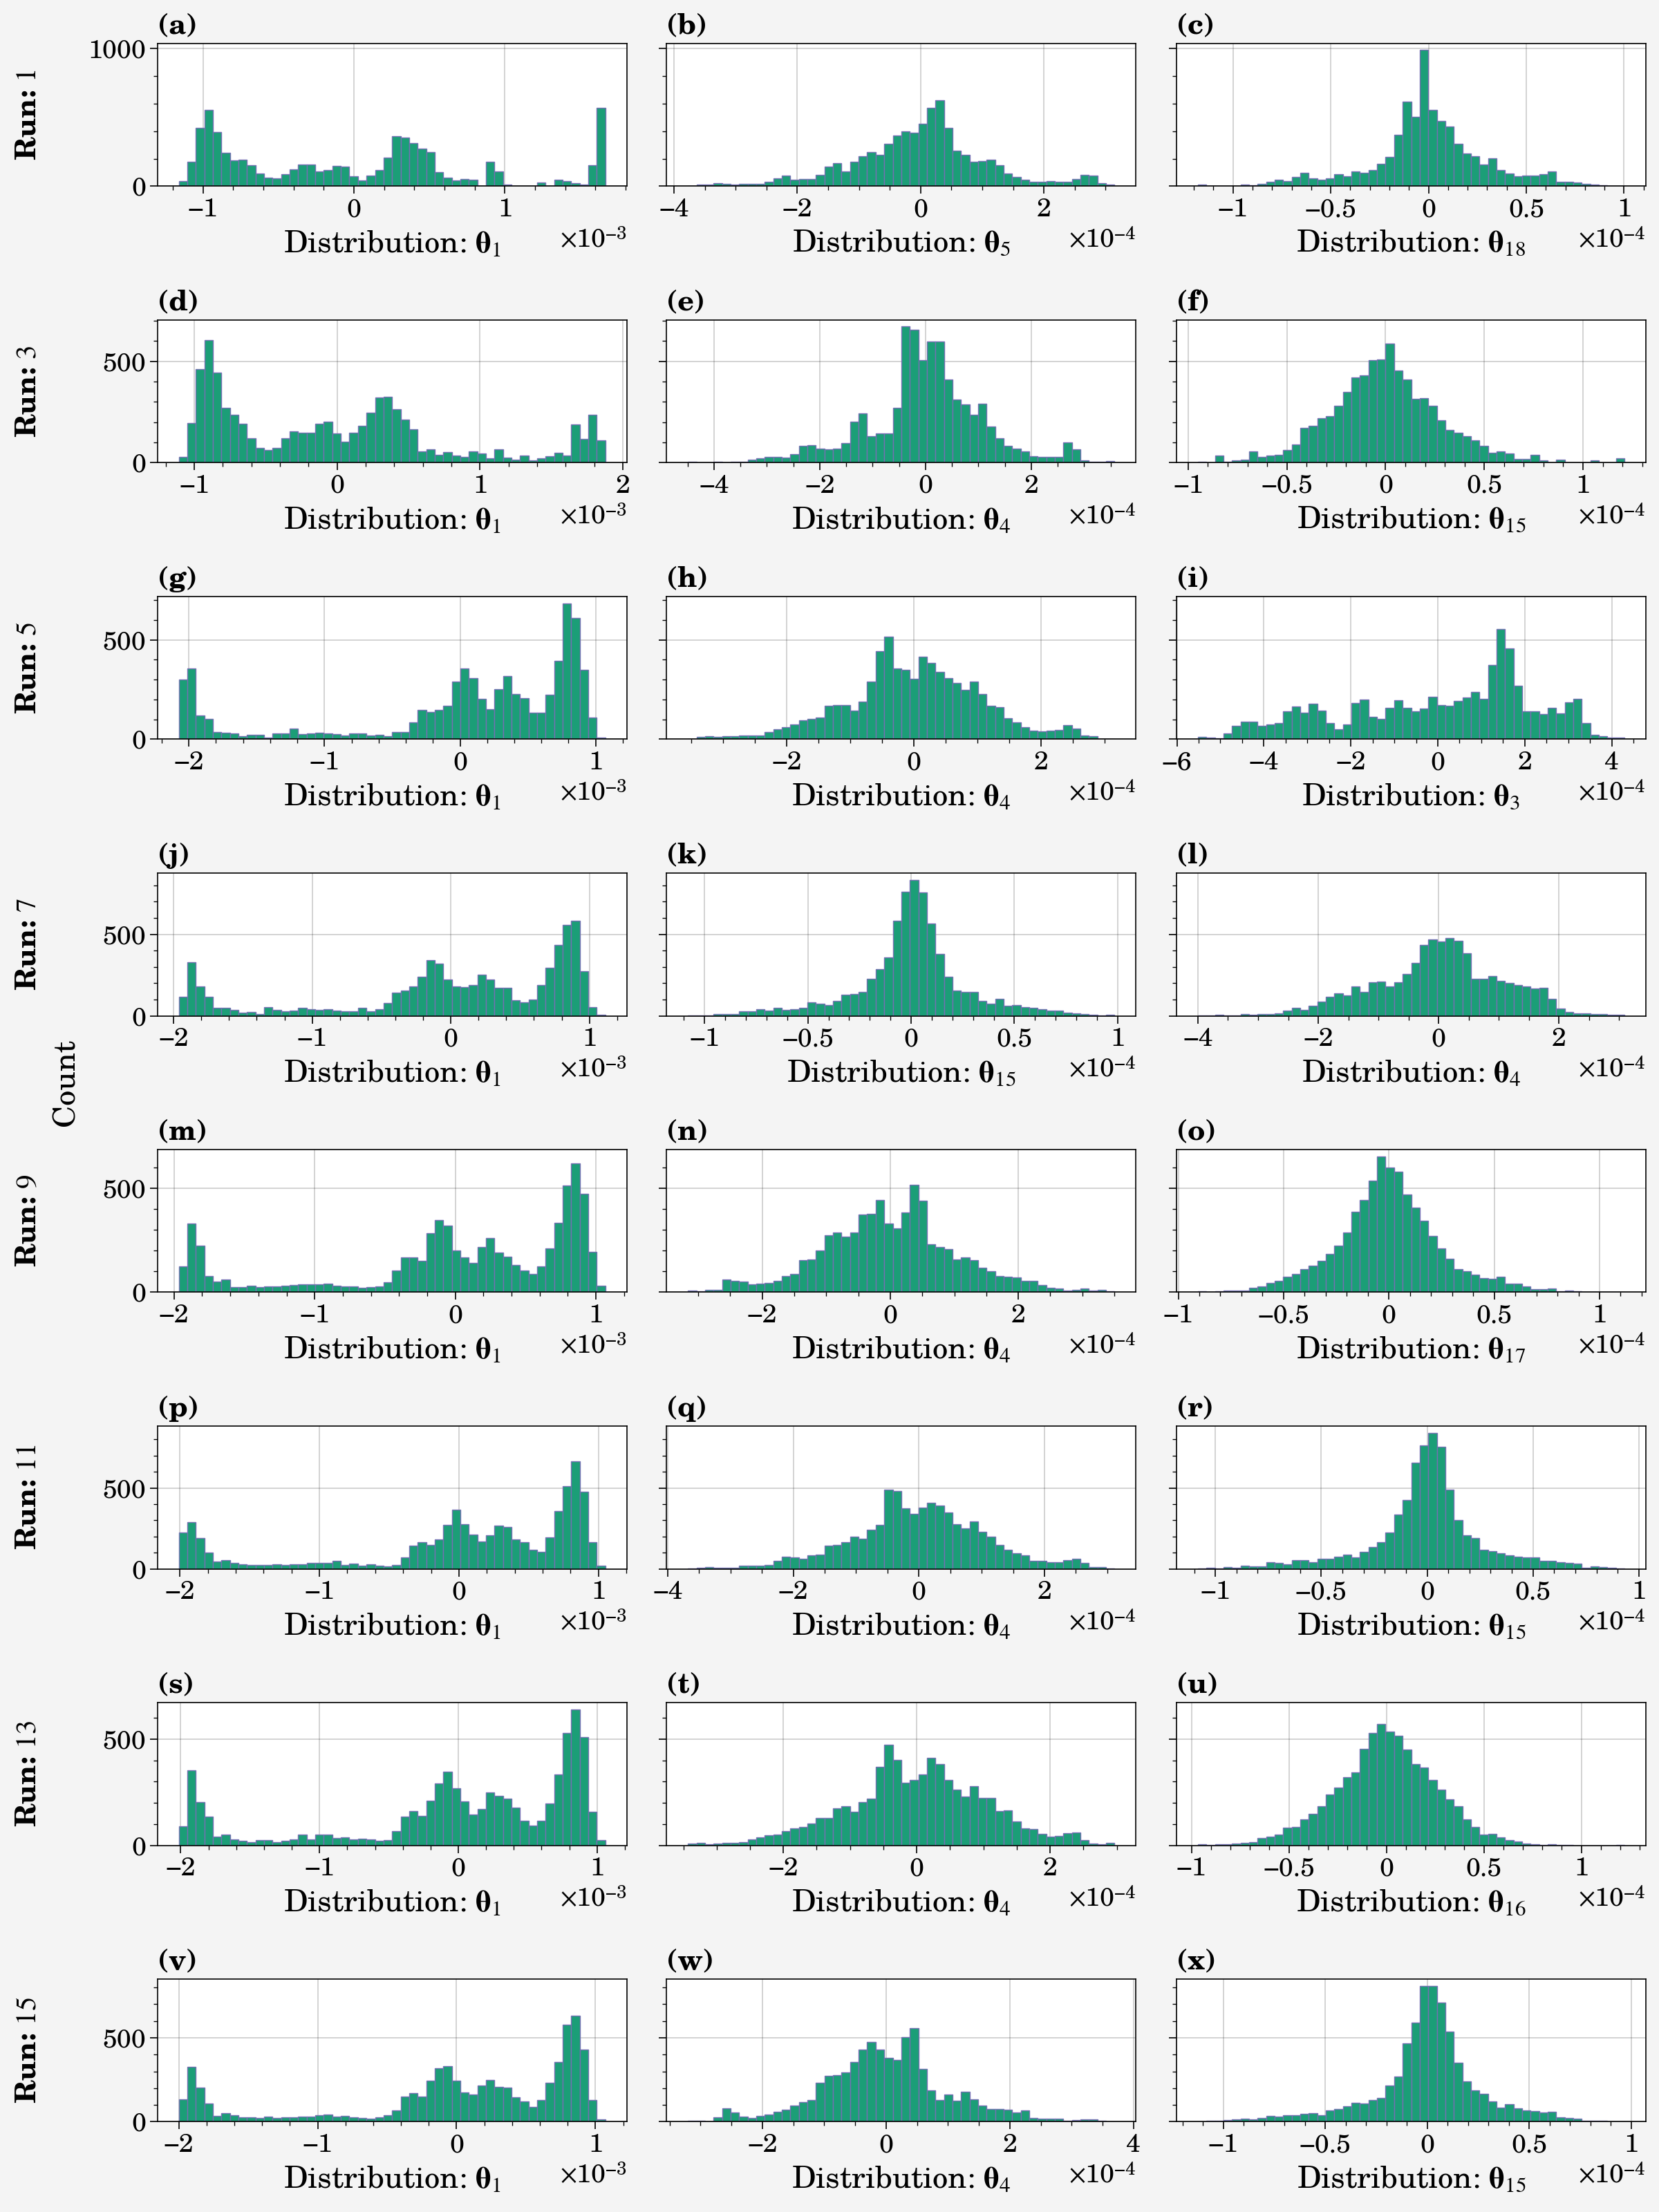

In [30]:
p=23

file_res = np.load(GDMaps_PATH+f'/DeepABM_parsim_20_runs_p_{p}.npz', allow_pickle=True)

evals_diff_runs = file_res['x1'] 
evecs_diff_runs = file_res['x2'] 
coord_diff_runs = file_res['x3']
g_diff_runs = file_res['x4']    
residuals_diff_runs = file_res['x5'] 
index_diff_runs = file_res['x6']  


fig, axs = pplt.subplots(ncols=3, nrows=8, figsize=(12, 16), sharex=False, sharey=True)

for run_i, run in enumerate(np.arange(0,16,2)):
    
    for coord_i, coord_n in enumerate(coord_diff_runs[run]):
        axs[run_i*3+coord_i].hist(g_diff_runs[run][:, coord_i], bins=50, 
                          facecolor = '#1b9e77', edgecolor='#7570b3', linewidth=0.5)
        axs[run_i*3+coord_i].format(abc='(a)', 
                                    xlabel='Distribution: ' + 
                                    r'$\mathbf{\theta}$'+r'$_{{{}}}$'.format(coord_n), 
                                    ylabel=r'Count')
axs.format(leftlabels=[r'Run: ${{{}}}$'.format(run+1) for run in np.arange(0,16,2)])

for ax in axs:
    ax.ticklabel_format(style="scientific", scilimits=(-2, -3), axis='x')

fig.tight_layout()
plt.savefig(f'plots/appendix/runs_coord_dist_p{p}.pdf', bbox_inches='tight')
plt.show()


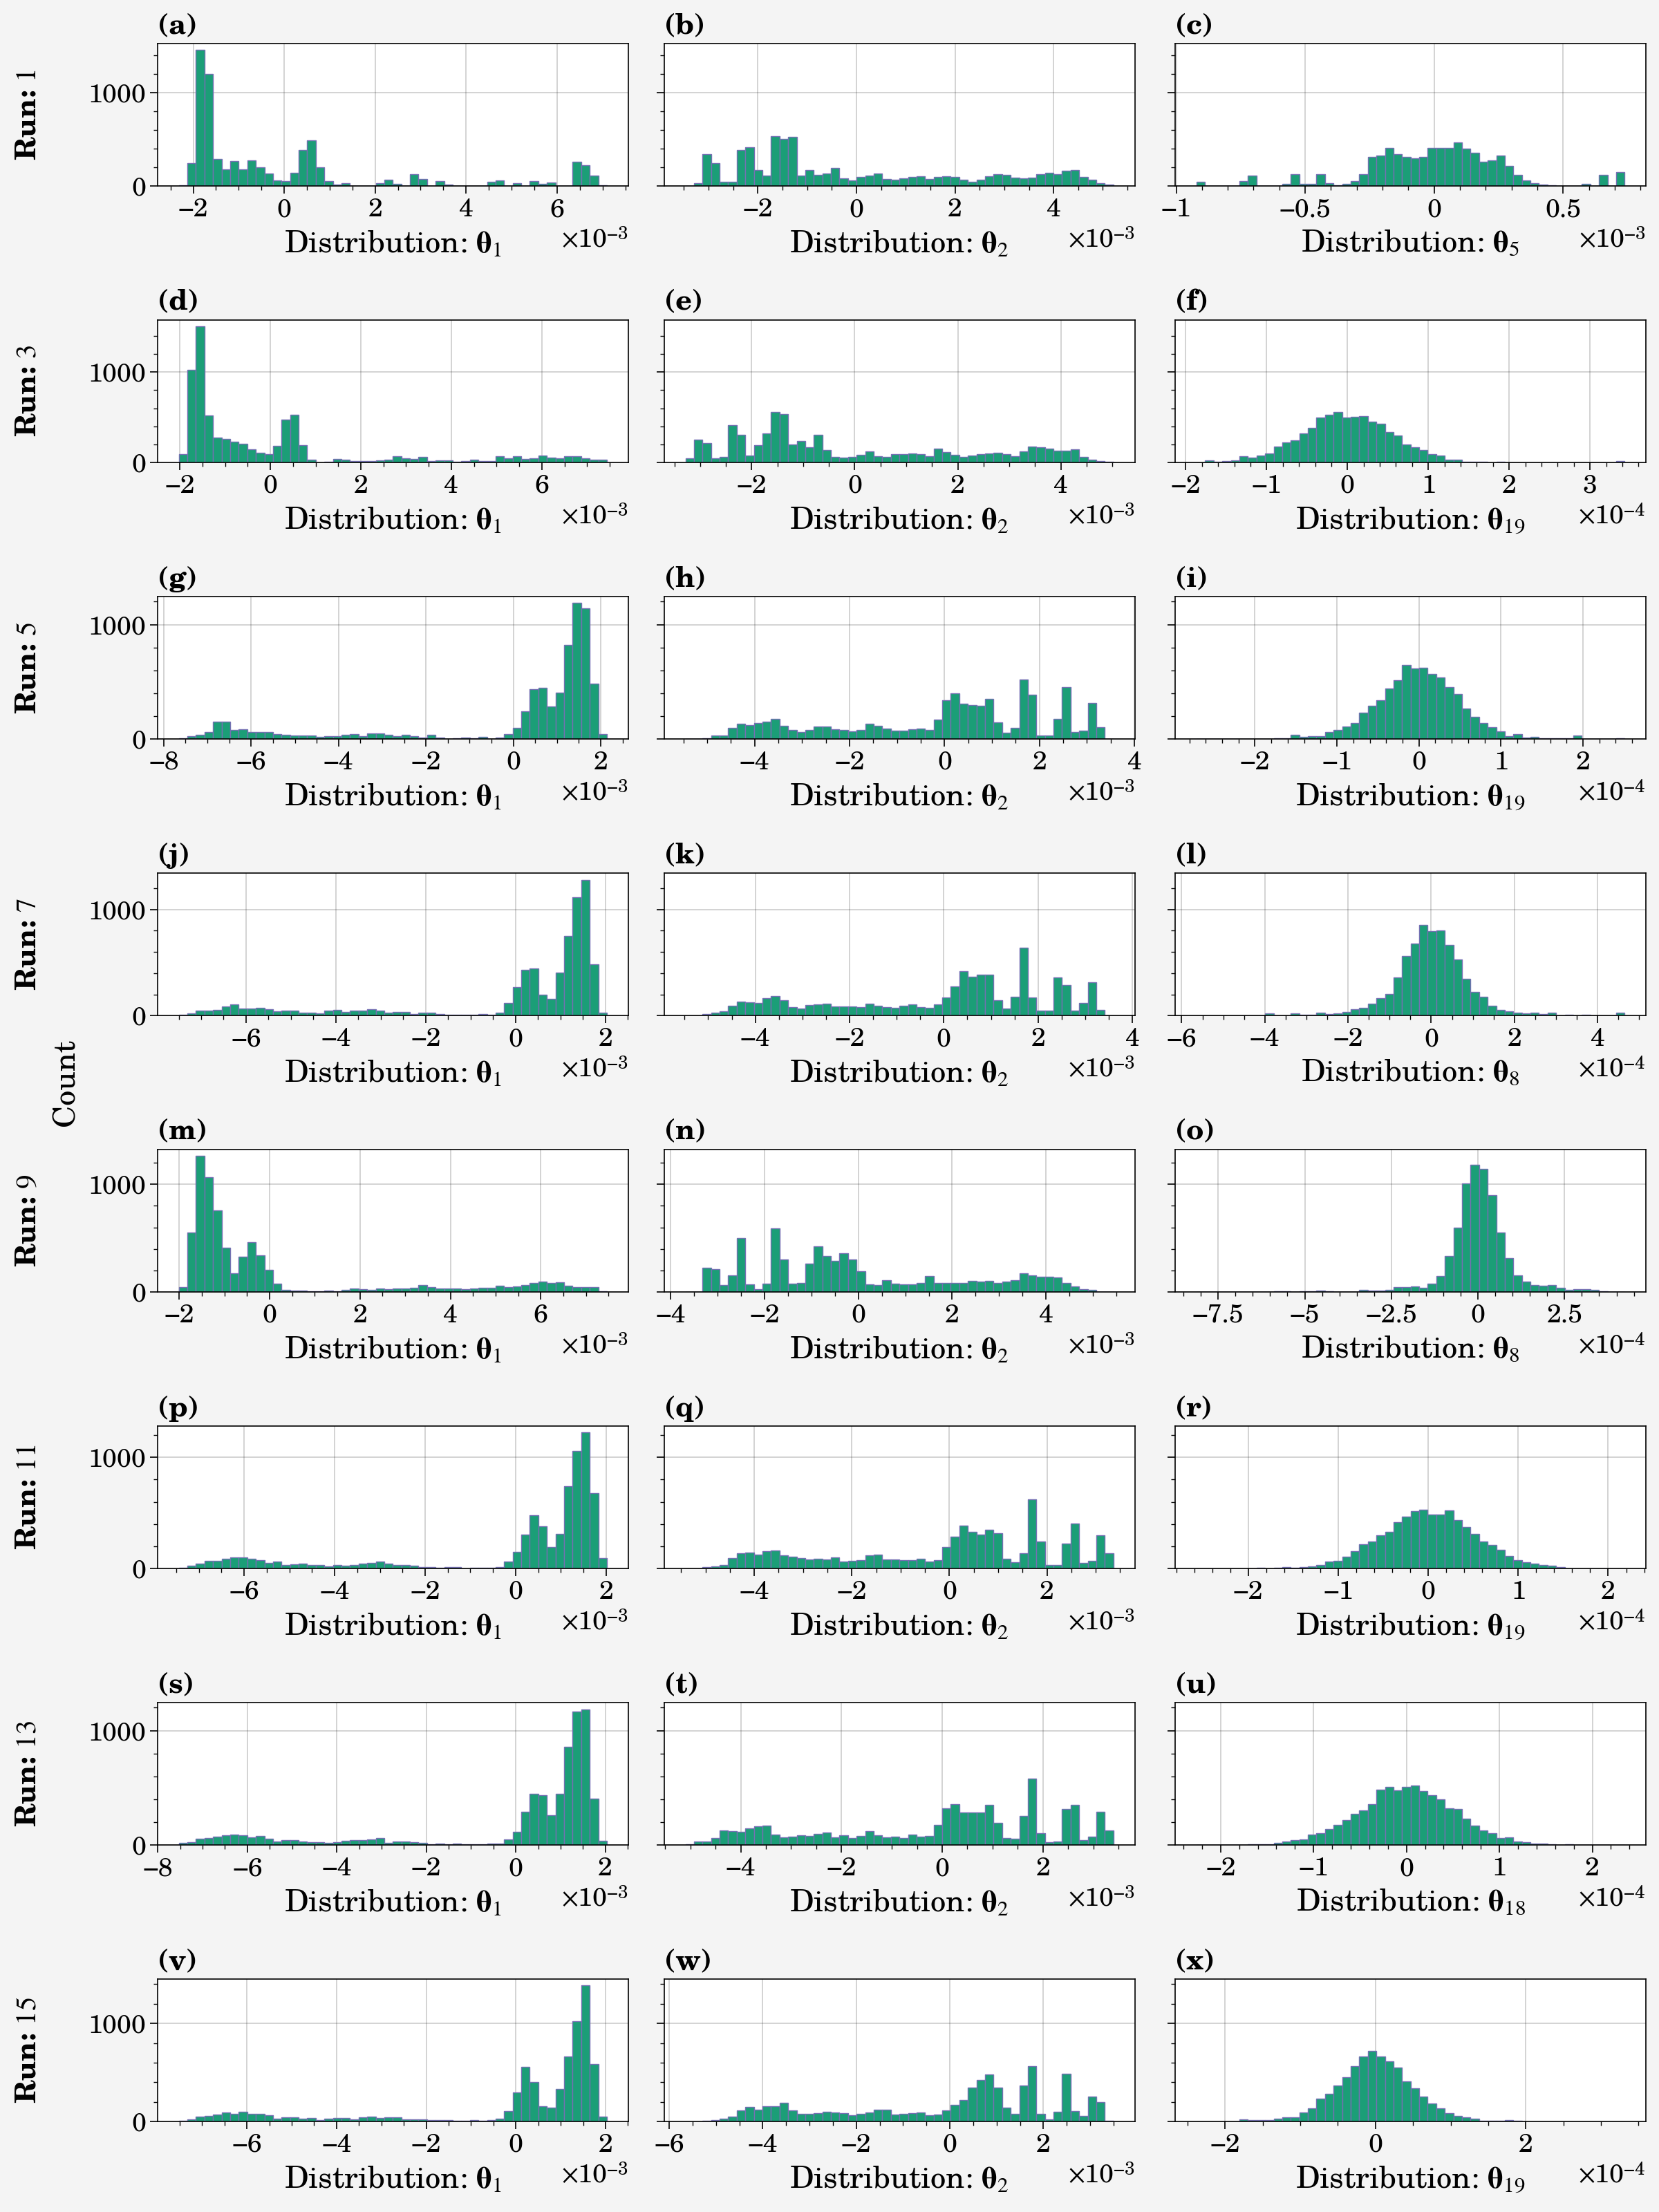

In [31]:
p=13

file_res = np.load(GDMaps_PATH+f'/DeepABM_parsim_20_runs_p_{p}.npz', allow_pickle=True)

evals_diff_runs = file_res['x1'] 
evecs_diff_runs = file_res['x2'] 
coord_diff_runs = file_res['x3']
g_diff_runs = file_res['x4']    
residuals_diff_runs = file_res['x5'] 
index_diff_runs = file_res['x6']  


fig, axs = pplt.subplots(ncols=3, nrows=8, figsize=(12, 16), sharex=False, sharey=True)

for run_i, run in enumerate(np.arange(0,16,2)):
    
    for coord_i, coord_n in enumerate(coord_diff_runs[run]):
        axs[run_i*3+coord_i].hist(g_diff_runs[run][:, coord_i], bins=50, 
                          facecolor = '#1b9e77', edgecolor='#7570b3', linewidth=0.5)
        axs[run_i*3+coord_i].format(abc='(a)', 
                                    xlabel='Distribution: ' 
                                    + r'$\mathbf{\theta}$'+r'$_{{{}}}$'.format(coord_n), 
                                    ylabel=r'Count')
axs.format(leftlabels=[r'Run: ${{{}}}$'.format(run+1) for run in np.arange(0,16,2)])

for ax in axs:
    ax.ticklabel_format(style="scientific", scilimits=(-2, -3), axis='x')

fig.tight_layout()
plt.savefig(f'plots/appendix/runs_coord_dist_p{p}.pdf', bbox_inches='tight')
plt.show()

In [36]:
p_array = [3, 13, 17, 22, 23, 24]

# parsimonious data
parsim_evals_p = {}
parsim_coords_p = {}
parsim_gs_p = {}

for p in p_array:
    file_res = np.load(GDMaps_PATH+f'/DeepABM_parsim_20_runs_p_{p}.npz', allow_pickle=True)

    evals_diff_runs = file_res['x1'] 
    coord_diff_runs = file_res['x3']
    g_diff_runs = file_res['x4']    
    
    parsim_evals_p[p] = evals_diff_runs
    parsim_coords_p[p] = coord_diff_runs
    parsim_gs_p[p] = g_diff_runs
    
    
    
# non-parsimonious data 
np_evals_p = {}
np_coords_p = {}
np_gs_p = {}

for p in p_array:
    file_res = np.load(GDMaps_PATH+f'/DeepABM_nonparsim_20_runs_p_{p}.npz', allow_pickle=True)

    evals_diff_runs = file_res['x1'] 
    coord_diff_runs = file_res['x3']
    g_diff_runs = file_res['x4']     

    np_evals_p[p] = evals_diff_runs
    np_coords_p[p] = np.atleast_2d(coord_diff_runs).repeat(repeats=20, axis=0)
    np_gs_p[p] = g_diff_runs
    


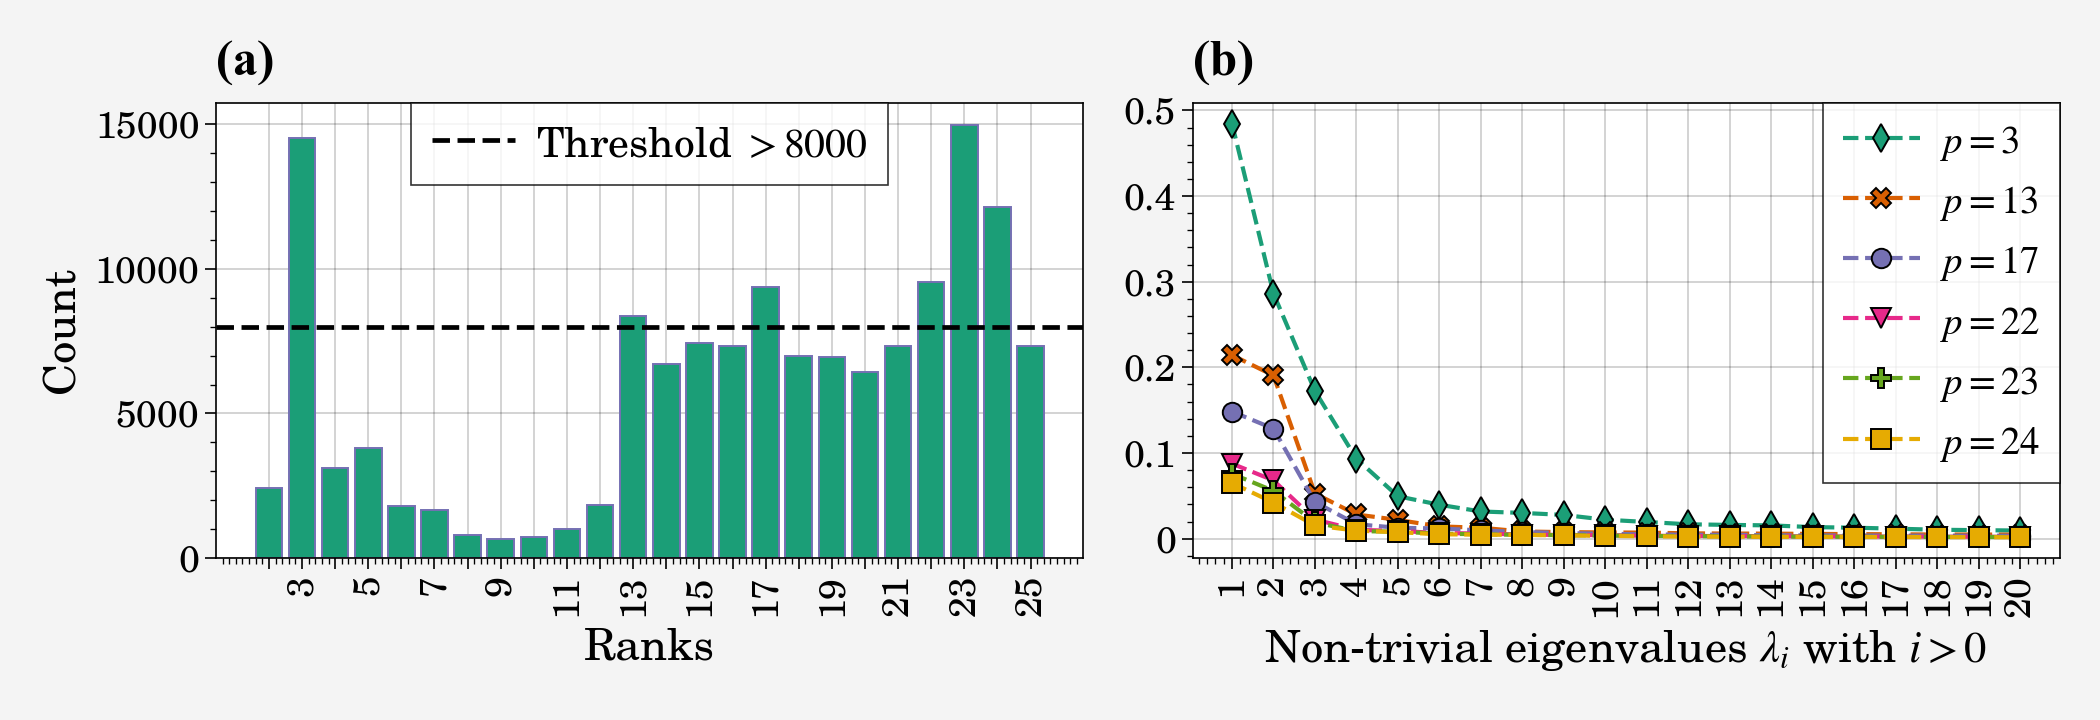

In [37]:
marker_styles = ['d--', 'X--', 'o--',  'v--', 'P--', 's--','*--']
colors=mcp.gen_color(cmap="Dark2",n=9)

run = 3

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(10.5, 3.6))
                        
for i, p in enumerate(p_array):
    axs[1].plot(np.arange(1, len(parsim_evals_p[p][run]), 1), 
                parsim_evals_p[p][run][1:], marker_styles[i], 
                label=r'$p={}$'.format(p), color=colors[i],
                markeredgecolor='k', markeredgewidth=0.7,
                markersize=7)
    axs[1].set_xlabel(r'Non-trivial eigenvalues $\lambda_i$ with $i > 0$')
    axs[1].legend(fontsize=14)
    xticks = np.arange(1, len(parsim_evals_p[p][run]), 1)
    axs[1].set_xticks(xticks,
                      ['{}'.format(num) for num in xticks], 
                      rotation=90)
axs[1].set_title('(b)', fontname="Times New Roman", size=18,
                 fontweight="bold", loc='left', pad=10)
    
axs[0].bar(unique, counts, facecolor = '#1b9e77', edgecolor='#7570b3', linewidth=0.7)
xticks_label = ['{}'.format(num) if num % 2 != 0 else ' ' for num in unique]
axs[0].set_xticks(unique, xticks_label, rotation=90)
axs[0].axhline(y=8000, xmin=0, xmax=26, c='k', 
               linewidth=1.7, ls='--', zorder=1, label=r'Threshold $>8000$')
axs[0].legend(fontsize=15)
axs[0].set(ylabel = r'Count', xlabel = r'Ranks')
axs[0].set_title('(a)', fontname="Times New Roman", size=18,
                 fontweight="bold", loc='left', pad=10)

plt.tight_layout()
plt.savefig('plots/main_text/ranks_hist_egenvals_diff_p.pdf', bbox_inches='tight')
plt.show()


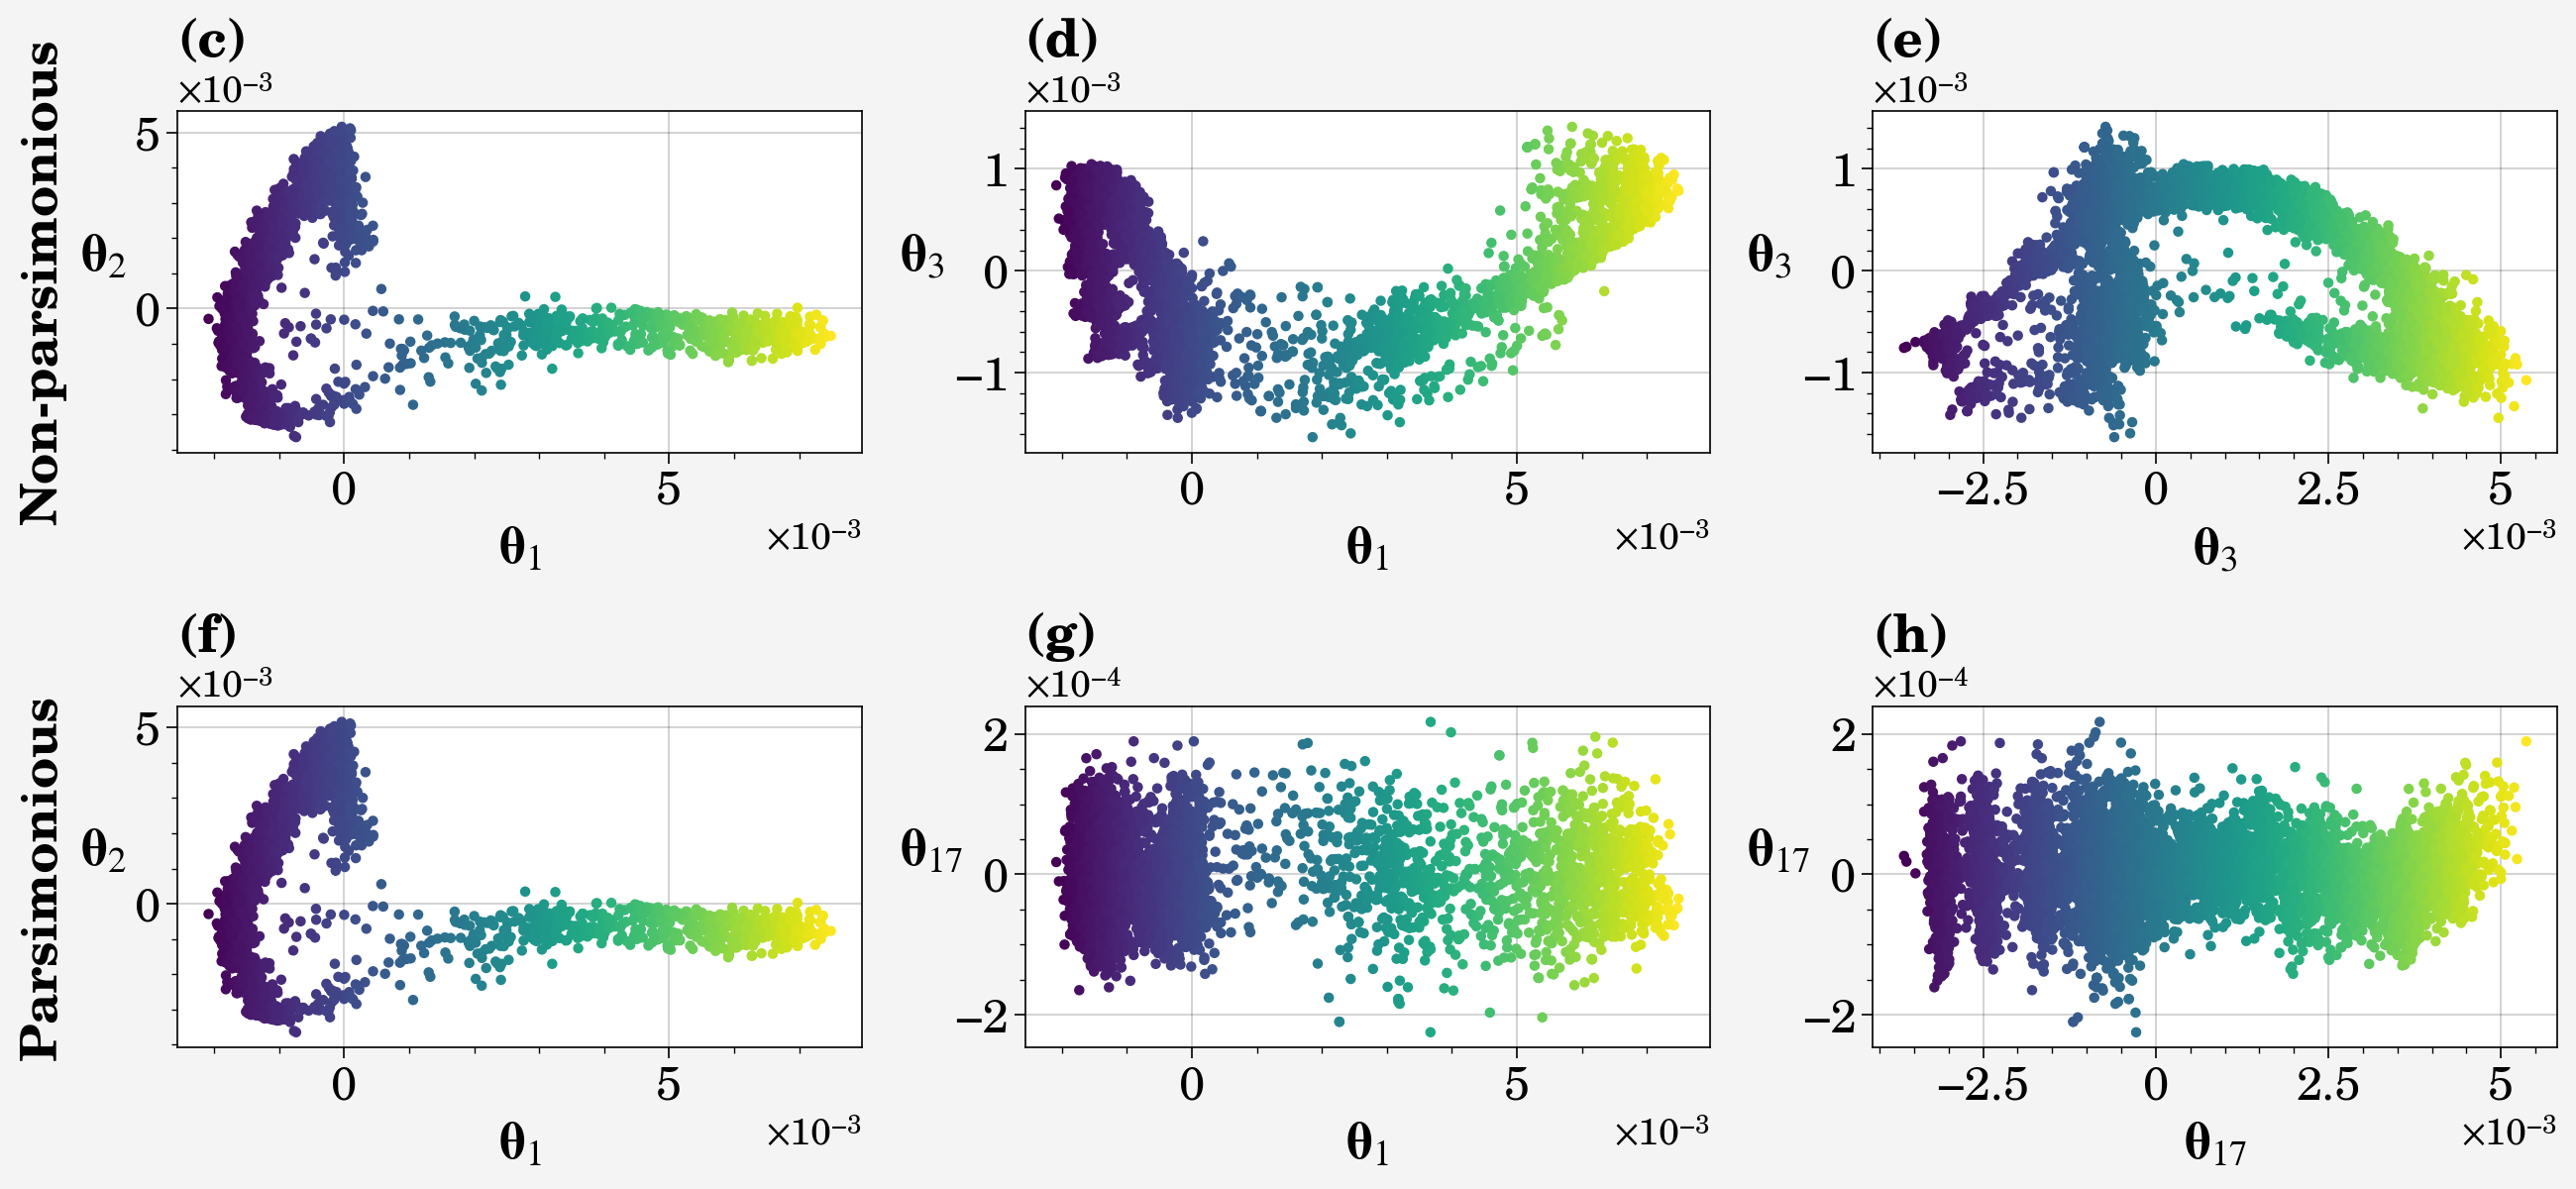

In [38]:
pplt.rc['title.pad']= 5.0 # default 5.0
pplt.rc['axes.labelsize'] = 16

numbering = ['(c)', '(d)', '(e)', '(f)', '(g)', '(h)']

run = 16
p = 13
fig, axs = pplt.subplots(ncols=3, nrows=2, figsize=(13, 6), sharex=False, sharey=False)

coord_data = [np_coords_p, parsim_coords_p]

for row, g_data in enumerate([np_gs_p, parsim_gs_p]):
    axs[row*3].scatter(g_data[p][run][:, 0][:512*7], g_data[p][run][:, 1][:512*7], 
                       c=g_data[p][run][:, 0][:512*7], cmap='viridis', 
                       s=10)
    axs[row*3].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][p][run][0]))
    axs[row*3].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][p][run][1]),
                           labelpad=20)
    
    axs[row*3+1].scatter(g_data[p][run][:, 0], g_data[p][run][:, 2], 
                         c=g_data[p][run][:, 0], cmap='viridis', 
                         s=10)                  
    axs[row*3+1].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][p][run][0]))
    axs[row*3+1].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][p][run][2]),
                           labelpad=20)

    axs[row*3+2].scatter(g_data[p][run][:, 1], g_data[p][run][:, 2], 
                         c=parsim_gs_p[p][run][:, 1], cmap='viridis', 
                         s=10)
#     edgecolors='k', linewidth=0.1)                   
    axs[row*3+2].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][p][run][2]))
    axs[row*3+2].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(coord_data[row][p][run][2]),
                           labelpad=20)
    
for i, ax in enumerate(axs):
    ax.format(title=numbering[i], titleloc='left', 
              titlepad=20, titleweight='bold')
    ax.ticklabel_format(style="scientific", scilimits=(-2, -3))
    ax.format(rc_kw={'title.size': 19,
                     'label.size': 19,
                     'tick.labelsize': 17,
                     'leftlabel.size': 18.5})
    ax.yaxis.label.set(rotation='horizontal', ha='left')

axs.format(leftlabels=['Non-parsimonious', 'Parsimonious'])

fig.tight_layout()
plt.savefig('plots/main_text/GDMaps_parsim_nonparsim_coords_16.pdf', dpi=300, bbox_inches='tight')
plt.show()       


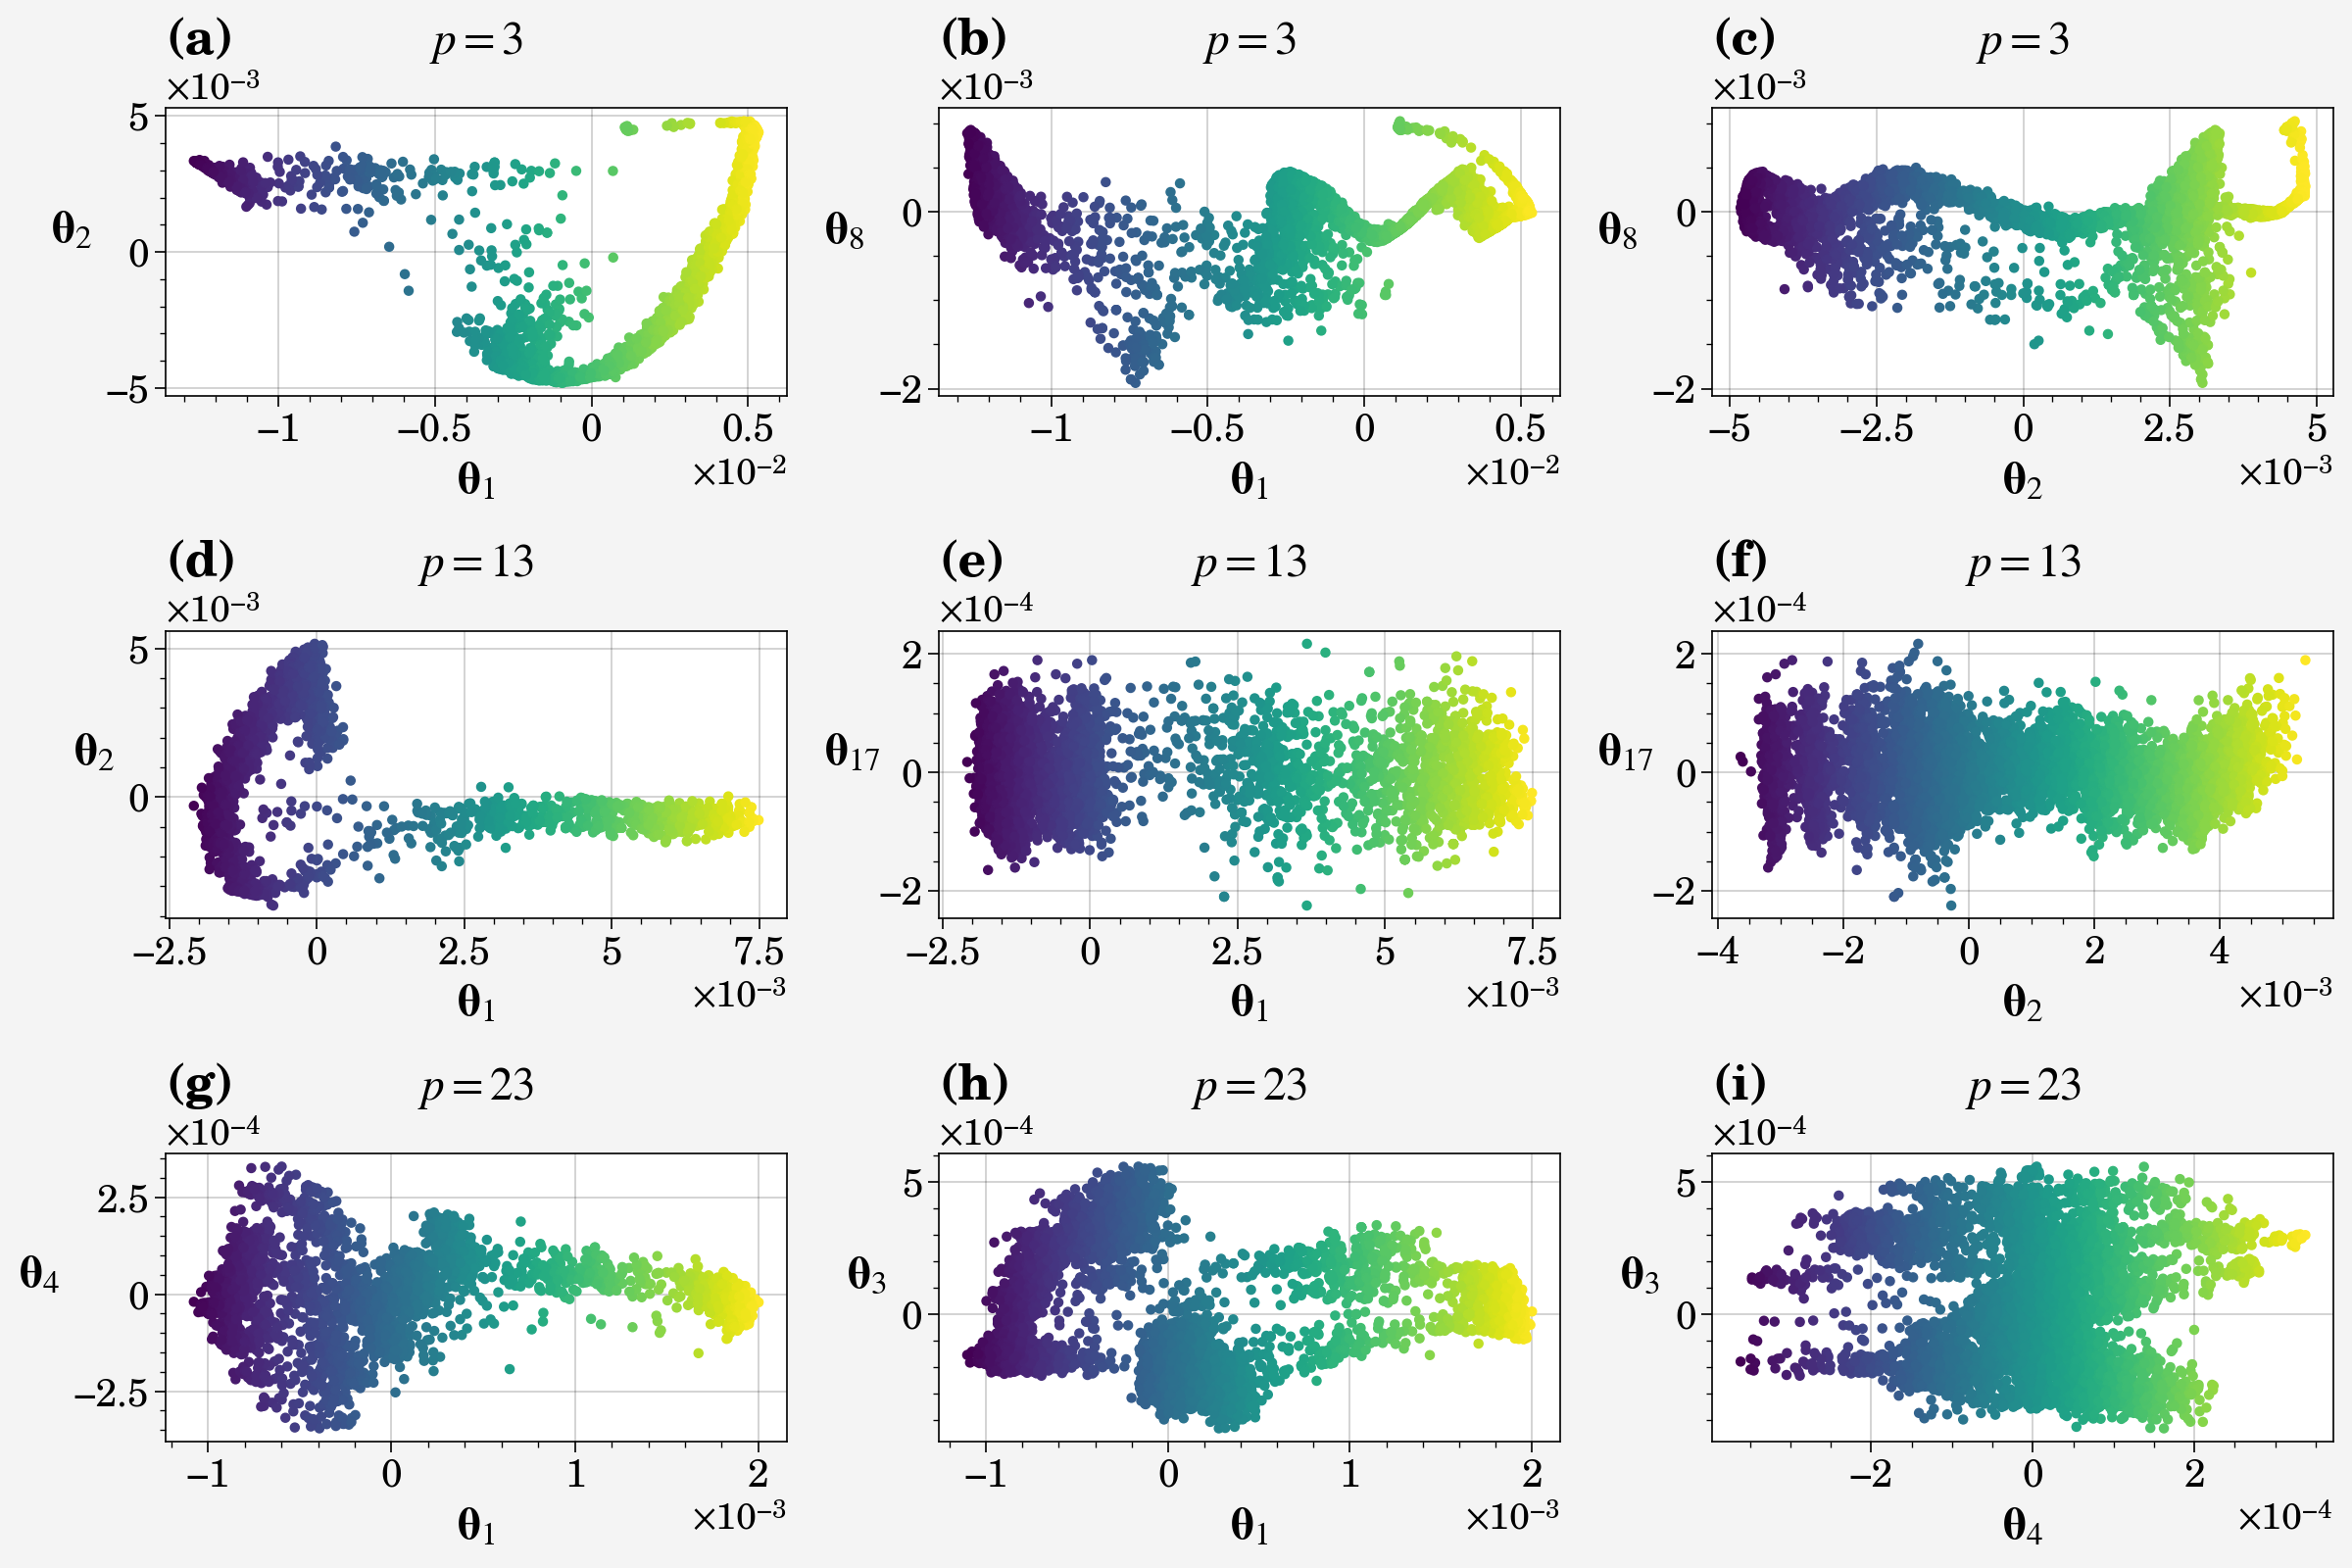

In [46]:
run = 16

p_array = [3, 13, 23]

pplt.rc['title.pad']= 15.0 # default 5.0


fig, axs = pplt.subplots(ncols=3, nrows=3, figsize=(12, 8), sharex=False, sharey=False)

for row, p in enumerate(p_array):
    
    axs[row*3].scatter(parsim_gs_p[p][run][:, 0][:512*7], parsim_gs_p[p][run][:, 1][:512*7], 
                       c=parsim_gs_p[p][run][:, 0][:512*7], cmap='viridis', 
                       s=10)
#                        edgecolors='k', linewidth=0.1)
    axs[row*3].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(parsim_coords_p[p][run][0]),
                      title=r'$p={}$'.format(p))
    axs[row*3].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(parsim_coords_p[p][run][1]),
                           labelpad=20)
    
    axs[row*3+1].scatter(parsim_gs_p[p][run][:, 0], parsim_gs_p[p][run][:, 2], 
                         c=parsim_gs_p[p][run][:, 0], cmap='viridis', 
                         s=10)
#     edgecolors='k', linewidth=0.1)
    axs[row*3+1].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(parsim_coords_p[p][run][0]),
                       title=r'$p={}$'.format(p))
    axs[row*3+1].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(parsim_coords_p[p][run][2]),
                           labelpad=20)

    
    axs[row*3+2].scatter(parsim_gs_p[p][run][:, 1], parsim_gs_p[p][run][:, 2], 
                         c=parsim_gs_p[p][run][:, 1], cmap='viridis', 
                         s=10)
#     edgecolors='k', linewidth=0.1)
    axs[row*3+2].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(parsim_coords_p[p][run][1]),
                       title=r'$p={}$'.format(p))
    axs[row*3+2].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(parsim_coords_p[p][run][2]),
                           labelpad=20)
    
    for ax in axs:
        ax.ticklabel_format(style="scientific", scilimits=(-2, -3))
        ax.format(abc='(a)',
                  rc_kw={'title.size': 17,
                         'label.size': 17,
                         'tick.labelsize': 14,
                         'abc.size': 18,
                         'title.pad': 20})
for i, ax in enumerate(axs):
    ax.yaxis.label.set(rotation='horizontal', ha='left')
    
fig.tight_layout()
plt.savefig('plots/appendix/parsim_dcoords_run16.pdf', dpi=300, bbox_inches='tight')
plt.show()



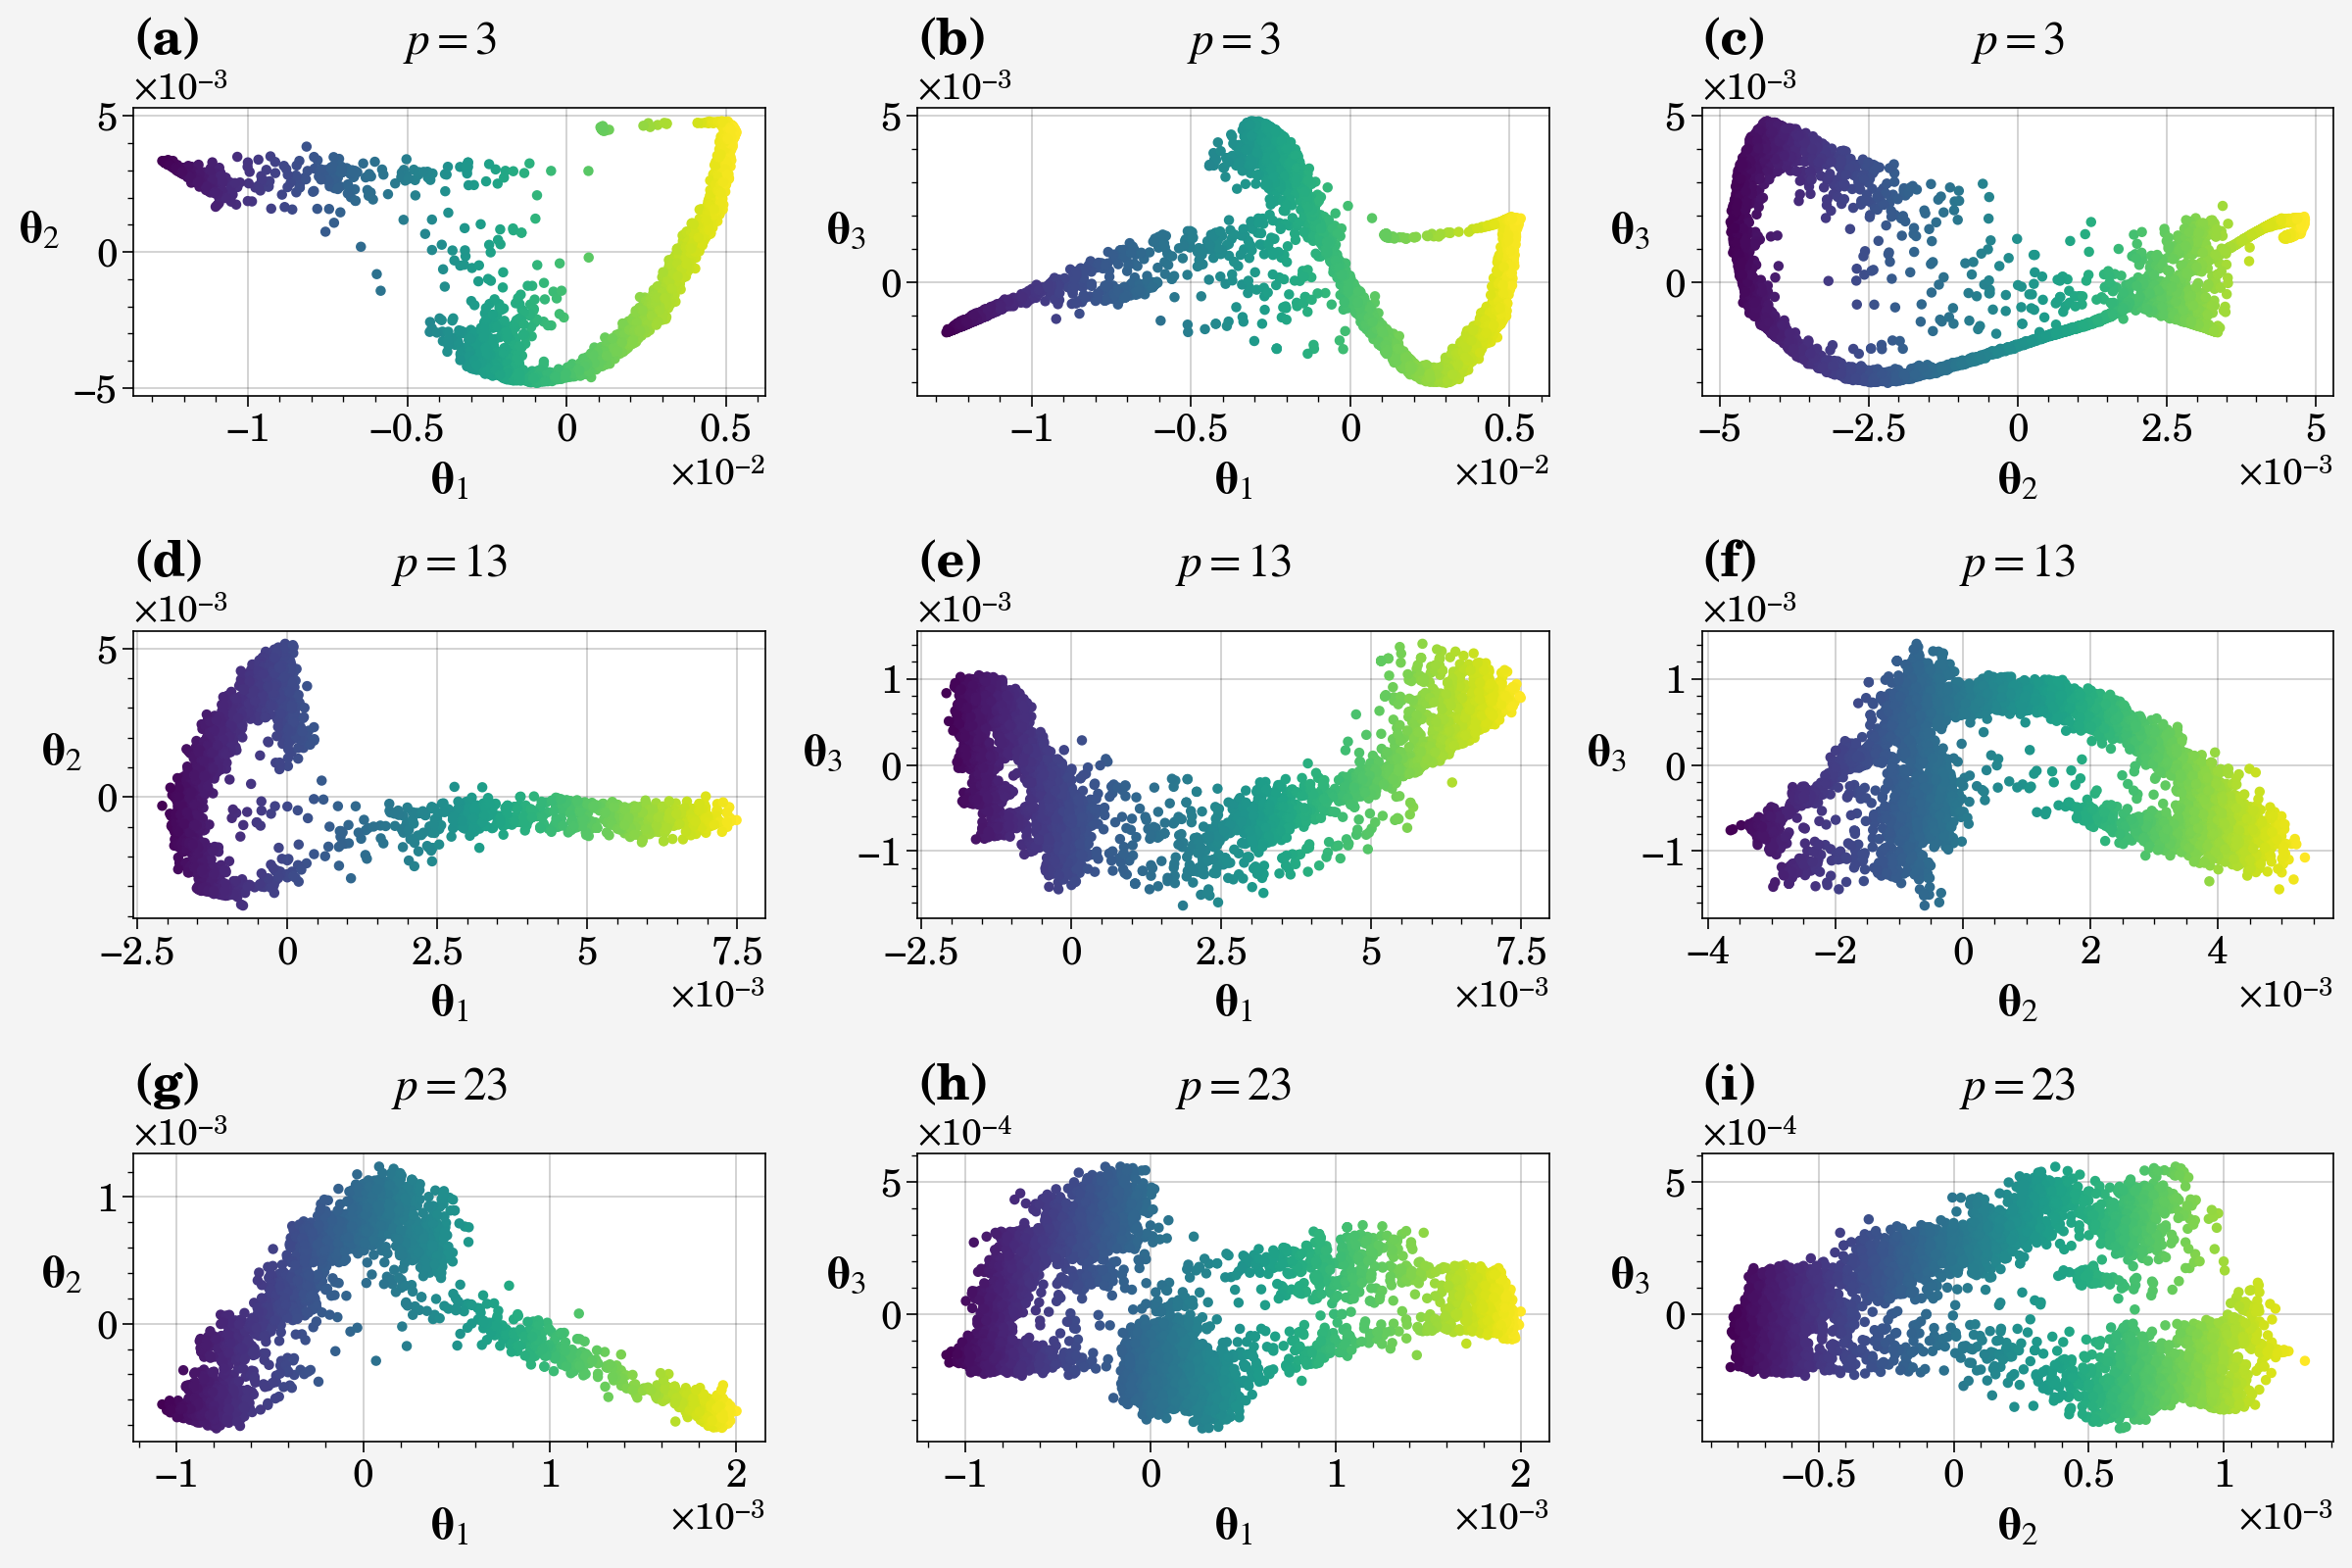

In [47]:
run = 16

p_array = [3, 13, 23]

pplt.rc['title.pad']= 15.0 # default 5.0

fig, axs = pplt.subplots(ncols=3, nrows=3, figsize=(12, 8), sharex=False, sharey=False)

for row, p in enumerate(p_array):
    
    axs[row*3].scatter(np_gs_p[p][run][:, 0][:512*7], np_gs_p[p][run][:, 1][:512*7], 
                       c=np_gs_p[p][run][:, 0][:512*7], cmap='viridis', 
                       s=10)
#     edgecolors='k', linewidth=0.1)
    
    axs[row*3].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(np_coords_p[p][run][0]),
                      title=r'$p={}$'.format(p))
    axs[row*3].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(np_coords_p[p][run][1]),
                           labelpad=20)
    
    axs[row*3+1].scatter(np_gs_p[p][run][:, 0], np_gs_p[p][run][:, 2], 
                         c=np_gs_p[p][run][:, 0], cmap='viridis', 
                         s=10)
#     edgecolors='k', linewidth=0.1)
    axs[row*3+1].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(np_coords_p[p][run][0]),
                       title=r'$p={}$'.format(p))
    axs[row*3+1].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(np_coords_p[p][run][2]),
                           labelpad=20)
    
    axs[row*3+2].scatter(np_gs_p[p][run][:, 1], np_gs_p[p][run][:, 2], 
                         c=np_gs_p[p][run][:, 1], cmap='viridis', 
                         s=10)
#     edgecolors='k', linewidth=0.1)
    axs[row*3+2].format(xlabel=r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(np_coords_p[p][run][1]),
                       title=r'$p={}$'.format(p))
    axs[row*3+2].set_ylabel(r"$\mathbf{\theta}$"+r"$_{{{}}}$".format(np_coords_p[p][run][2]),
                           labelpad=20)
    
    for ax in axs:
        ax.ticklabel_format(style="scientific", scilimits=(-2, -3))
        ax.format(abc='(a)',
                  rc_kw={'title.size': 17,
                         'label.size': 17,
                         'tick.labelsize': 14,
                         'abc.size': 18,
                         'title.pad': 20})
for i, ax in enumerate(axs):
    ax.yaxis.label.set(rotation='horizontal', ha='left')
    
    
fig.tight_layout()
plt.savefig('plots/appendix/nonparsim_dcoords_run16.pdf', dpi=300, bbox_inches='tight')
plt.show()